# **Data Analysis**
**Andreas Heindl**

WS2025
## Solar Power Plant Data

In [120]:
# Import the necessary libraries
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from umap import UMAP


# 1. Choose Dataset
## Dataset Description

**Dataset name and source:**
- Name: solar-power-generation-data
- Source: anikanna from kagglehub



In [121]:
# Download Dataset
# Use agglehub to download the latest version of the solar power Generation dataset.
path = kagglehub.dataset_download("anikannal/solar-power-generation-data")

# Print the path to dataset files
print("Path to dataset files:", path)

Path to dataset files: C:\Users\RandyAndy\.cache\kagglehub\datasets\anikannal\solar-power-generation-data\versions\1


In [122]:
# Load the first dataset into a pandas DataFrame
file_path_generation = os.path.join(path, "Plant_1_Generation_Data.csv")
generation_data_initial = pd.read_csv(file_path_generation)

file_path_weather = os.path.join(path, "Plant_1_Weather_Sensor_Data.csv")
weather_data_initial = pd.read_csv(file_path_weather)

# 2.1 A Data Preprocessing and Data Quality (70 points)

## Dataset overview (dimensions, columns, types, time range, sampling rate, missingness summary) (10 points)

In [ ]:
def print_overview(df):
    # Dimenstions
    print("Shape:", df.shape)

    # Columns and data types
    print("\nColumns and data types:")
    print(df.dtypes)

    # Time range
    tmin = df["DATE_TIME"].min(); tmax = df["DATE_TIME"].max()
    print("\nTime range:", tmin, "to", tmax)
    diffs = df["DATE_TIME"].drop_duplicates().diff().dropna()
    med = diffs.median()

    # Sampling rate
    print("Sampling median:", med)
    print("Sampling rate (minutes):", med.total_seconds() / 60)

    # Missingness summary
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df) * 100).round(2)
    overview_df = pd.DataFrame({
        "missing_count": missing_counts,
        "missing_percent": missing_percent,
    }).sort_values("missing_percent", ascending=False)
    print("\nMissingness summary:")
    display(overview_df.head(20))
    print("\n")

    # Missing timestamps
    df_sorted = df.sort_values("DATE_TIME")
    df_sorted["TIME_DIFF"] = df_sorted["DATE_TIME"].diff()
    expected_diff = med
    large_gaps = df_sorted[df_sorted["TIME_DIFF"] > expected_diff]
    print("Large time gaps (greater than expected sampling rate):")
    display(large_gaps[["DATE_TIME", "TIME_DIFF"]])
    print("\n")


# Had issue with datetime format, convert to a known format
generation_data_initial["DATE_TIME"] = pd.to_datetime(generation_data_initial["DATE_TIME"], format="%d-%m-%Y %H:%M", dayfirst=True)

# Convert weather DATE_TIME using the known format for this dataset
weather_data_initial["DATE_TIME"] = pd.to_datetime(weather_data_initial["DATE_TIME"], format="%Y-%m-%d %H:%M:%S")

# Run for both datasets
print("\nGeneration Data Overview:")
print_overview(generation_data_initial)

print("\nWeather Data Overview:")
print_overview(weather_data_initial)


Generation Data Overview:
Shape: (68778, 7)

Columns and data types:
DATE_TIME      datetime64[ns]
PLANT_ID                int64
SOURCE_KEY             object
DC_POWER              float64
AC_POWER              float64
DAILY_YIELD           float64
TOTAL_YIELD           float64
dtype: object

Time range: 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Sampling median: 0 days 00:15:00
Sampling rate (minutes): 15.0

Missingness summary:


,missing_count,missing_percent
DATE_TIME,0,0.0
PLANT_ID,0,0.0
SOURCE_KEY,0,0.0
DC_POWER,0,0.0
AC_POWER,0,0.0
DAILY_YIELD,0,0.0
TOTAL_YIELD,0,0.0




Large time gaps (greater than expected sampling rate):


,DATE_TIME,TIME_DIFF
1965,2020-05-16 02:00:00,0 days 03:00:00
9159,2020-05-19 12:30:00,0 days 01:00:00
11302,2020-05-20 17:30:00,0 days 04:15:00
11785,2020-05-21 07:45:00,0 days 09:00:00
15644,2020-05-23 06:45:00,0 days 01:45:00
16973,2020-05-23 22:00:00,0 days 00:30:00
19737,2020-05-25 06:00:00,0 days 00:30:00
27418,2020-05-29 06:15:00,0 days 08:00:00
67272,2020-06-17 06:45:00,0 days 00:45:00





Weather Data Overview:
Shape: (3182, 6)

Columns and data types:
DATE_TIME              datetime64[ns]
PLANT_ID                        int64
SOURCE_KEY                     object
AMBIENT_TEMPERATURE           float64
MODULE_TEMPERATURE            float64
IRRADIATION                   float64
dtype: object

Time range: 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Sampling median: 0 days 00:15:00
Sampling rate (minutes): 15.0

Missingness summary:


,missing_count,missing_percent
DATE_TIME,0,0.0
PLANT_ID,0,0.0
SOURCE_KEY,0,0.0
AMBIENT_TEMPERATURE,0,0.0
MODULE_TEMPERATURE,0,0.0
IRRADIATION,0,0.0




Large time gaps (greater than expected sampling rate):


,DATE_TIME,TIME_DIFF
93,2020-05-16 02:00:00,0 days 03:00:00
420,2020-05-19 12:30:00,0 days 01:00:00
520,2020-05-20 17:30:00,0 days 04:15:00
549,2020-05-21 07:45:00,0 days 07:15:00
732,2020-05-23 06:45:00,0 days 01:30:00
792,2020-05-23 22:00:00,0 days 00:30:00
1288,2020-05-29 06:15:00,0 days 04:30:00
1799,2020-06-03 14:15:00,0 days 00:30:00


## Basic statistical analysis using pandas (descriptives, grouped stats, quantiles) (10 points)

In [ ]:
# Grouped statistics and quantiles
print("Generation Data grouped stats and quantiles:")
describe = generation_data_initial[["AC_POWER", "DC_POWER", "TOTAL_YIELD", "DAILY_YIELD"]].describe(percentiles=[0.25, 0.5, 0.75])
display(describe)

print("\nWeather Data grouped stats and quantiles:")
describe_weather = weather_data_initial[["IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]].describe(percentiles=[0.25, 0.5, 0.75])
display(describe_weather)

# Grouped stats of inverter/source keys
print("\nGeneration Data grouped stats by SOURCE_KEY:")
grouped_generation = generation_data_initial.groupby("SOURCE_KEY")[["AC_POWER", "DC_POWER", "TOTAL_YIELD", "DAILY_YIELD"]].agg(["mean", "median", "std", "min", "max"])
display(grouped_generation) 

# Time based hourly patterns
generation_data_initial["HOUR"] = generation_data_initial["DATE_TIME"].dt.hour
hourly_stats = generation_data_initial.groupby("HOUR")[["AC_POWER", "DC_POWER"]].mean()
print("\nHourly average AC_POWER and DC_POWER:")
display(hourly_stats)

Generation Data grouped stats and quantiles:


,AC_POWER,DC_POWER,TOTAL_YIELD,DAILY_YIELD
count,68778.000000,68778.000000,6.877800e+04,68778.000000
mean,307.802752,3147.426211,6.978712e+06,3295.968737
std,394.396439,4036.457169,4.162720e+05,3145.178309
min,0.000000,0.000000,6.183645e+06,0.000000
25%,0.000000,0.000000,6.512003e+06,0.000000
50%,41.493750,429.000000,7.146685e+06,2658.714286
75%,623.618750,6366.964286,7.268706e+06,6274.000000
max,1410.950000,14471.125000,7.846821e+06,9163.000000



Weather Data grouped stats and quantiles:


,IRRADIATION,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE
count,3182.000000,3182.000000,3182.000000
mean,0.228313,25.531606,31.091015
std,0.300836,3.354856,12.261222
min,0.000000,20.398505,18.140415
25%,0.000000,22.705182,21.090553
50%,0.024653,24.613814,24.618060
75%,0.449588,27.920532,41.307840
max,1.221652,35.252486,65.545714



Generation Data grouped stats by SOURCE_KEY:


AC_POWER                                           \
                       mean     median         std  min          max   
SOURCE_KEY                                                             
1BY6WEcLGh8j5v7  281.124073  29.261607  367.646871  0.0  1300.171429   
1IF53ai7Xc0U56Y  315.488026  43.687500  402.301747  0.0  1394.514286   
3PZuoBAID5Wc2HD  314.967354  44.123214  402.373790  0.0  1399.225000   
7JYdWkrLSPkdwr4  306.385671  42.428571  392.300240  0.0  1384.871429   
McdE0feGgRqW7Ca  314.046321  42.502679  402.278537  0.0  1405.800000   
VHMLBKoKgIrUVDU  313.900096  43.214286  402.009046  0.0  1394.214286   
WRmjgnKYAwPKWDb  308.575465  43.457143  393.673488  0.0  1376.350000   
YxYtjZvoooNbGkE  310.930334  46.478571  395.711539  0.0  1410.528571   
ZnxXDlPa8U1GXgE  312.346427  42.379464  399.791497  0.0  1391.642857   
ZoEaEvLYb1n2sOq  306.980623  43.600000  391.891363  0.0  1395.485714   
adLQvlD726eNBSB  319.693862  45.400000  407.920560  0.0  1405.585714   
bvBOhCH3iADSZry  276.778938  27.514286  361.579929  0.0  1265.157143   
iCRJl6heRkivqQ3  312.540320  42.742857  399.354809  0.0  1407.542857   
ih0vzX44oOqAx2f  302.962438  41.450000  388.040381  0.0  1377.314286   
pkci93gMrogZuBj  309.670213  42.528571  394.942694  0.0  1379.625000   
rGa61gmuvPhdLxV  309.345658  43.106250  394.750370  0.0  1392.842857   
sjndEbLyjtCKgGv  307.912265  41.750000  393.687601  0.0  1399.842857   
uHbuxQJl8lW7ozc  312.467844  43.385714  398.359247  0.0  1377.250000   
wCURE6d3bPkepu2  310.064044  41.916071  398.780301  0.0  1410.950000   
z9Y9gH1T5YWrNuG  306.492026  40.021429  393.570990  0.0  1401.125000   
zBIq5rxdHJRwDNY  307.925344  42.685714  393.246025  0.0  1393.242857   
zVJPv84UY57bAof  311.676665  42.550000  398.685362  0.0  1397.085714   

                    DC_POWER                                             \
                        mean      median          std  min          max   
SOURCE_KEY                                                                
1BY6WEcLGh8j5v7  2873.720981  302.955357  3761.145773  0.0  13335.14286   
1IF53ai7Xc0U56Y  3226.336768  451.625000  4117.942833  0.0  14302.71429   
3PZuoBAID5Wc2HD  3221.015673  456.160714  4118.576051  0.0  14351.12500   
7JYdWkrLSPkdwr4  3132.891955  438.571429  4014.963827  0.0  14204.00000   
McdE0feGgRqW7Ca  3211.307245  439.571429  4117.113844  0.0  14418.42857   
VHMLBKoKgIrUVDU  3210.102563  446.714286  4114.886897  0.0  14299.85714   
WRmjgnKYAwPKWDb  3155.384433  449.428571  4029.070312  0.0  14116.25000   
YxYtjZvoooNbGkE  3179.492570  480.642857  4050.058516  0.0  14466.85714   
ZnxXDlPa8U1GXgE  3194.059104  438.258929  4092.017013  0.0  14273.28571   
ZoEaEvLYb1n2sOq  3139.009808  451.000000  4010.701129  0.0  14312.71429   
adLQvlD726eNBSB  3269.567669  469.857143  4175.815364  0.0  14416.14286   
bvBOhCH3iADSZry  2828.998291  285.000000  3698.531647  0.0  12976.00000   
iCRJl6heRkivqQ3  3196.074675  442.285714  4087.526979  0.0  14436.28571   
ih0vzX44oOqAx2f  3097.714161  428.571429  3971.122441  0.0  14126.42857   
pkci93gMrogZuBj  3166.599439  439.714286  4042.101194  0.0  14149.87500   
rGa61gmuvPhdLxV  3163.240929  445.830357  4040.112422  0.0  14285.71429   
sjndEbLyjtCKgGv  3148.270450  431.750000  4028.665755  0.0  14357.42857   
uHbuxQJl8lW7ozc  3195.316080  448.571429  4077.234652  0.0  14125.62500   
wCURE6d3bPkepu2  3170.704424  433.446429  4081.628327  0.0  14471.12500   
z9Y9gH1T5YWrNuG  3134.037738  414.000000  4028.058883  0.0  14370.50000   
zBIq5rxdHJRwDNY  3148.590013  441.428571  4024.500149  0.0  14289.57143   
zVJPv84UY57bAof  3187.236622  440.125000  4080.647086  0.0  14329.14286   

                  TOTAL_YIELD                                         \
                         mean        median           std        min   
SOURCE_KEY                                                             
1BY6WEcLGh8j5v7  6.377464e+06  6.381896e+06  66899.659902  6259559.0   
1IF53ai7Xc0U56Y  6.313086e+06  6.317141e+06  73427.330


Hourly average AC_POWER and DC_POWER:


,AC_POWER,DC_POWER
HOUR,,
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
5,0.000000,0.000000
6,56.135778,578.113622
7,250.239163,2551.386720
8,498.911000,5088.628218


## Original data quality analysis with visualization (missingness patterns, outliers, duplicates, timestamp gaps, inconsistent units) (20 points)


Here we can see the wrong DC power (factor 10)


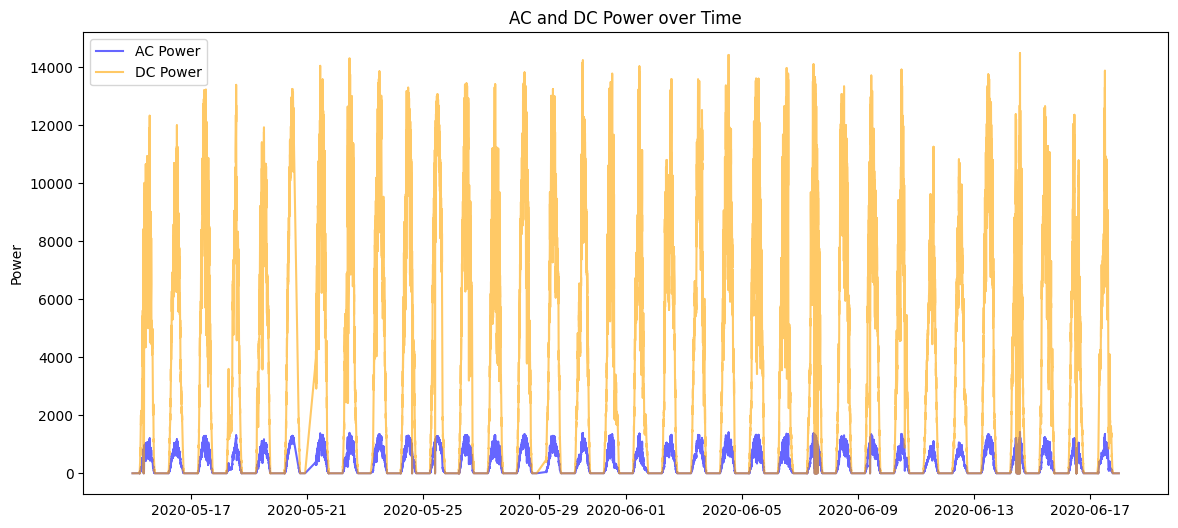


Other generation data columns


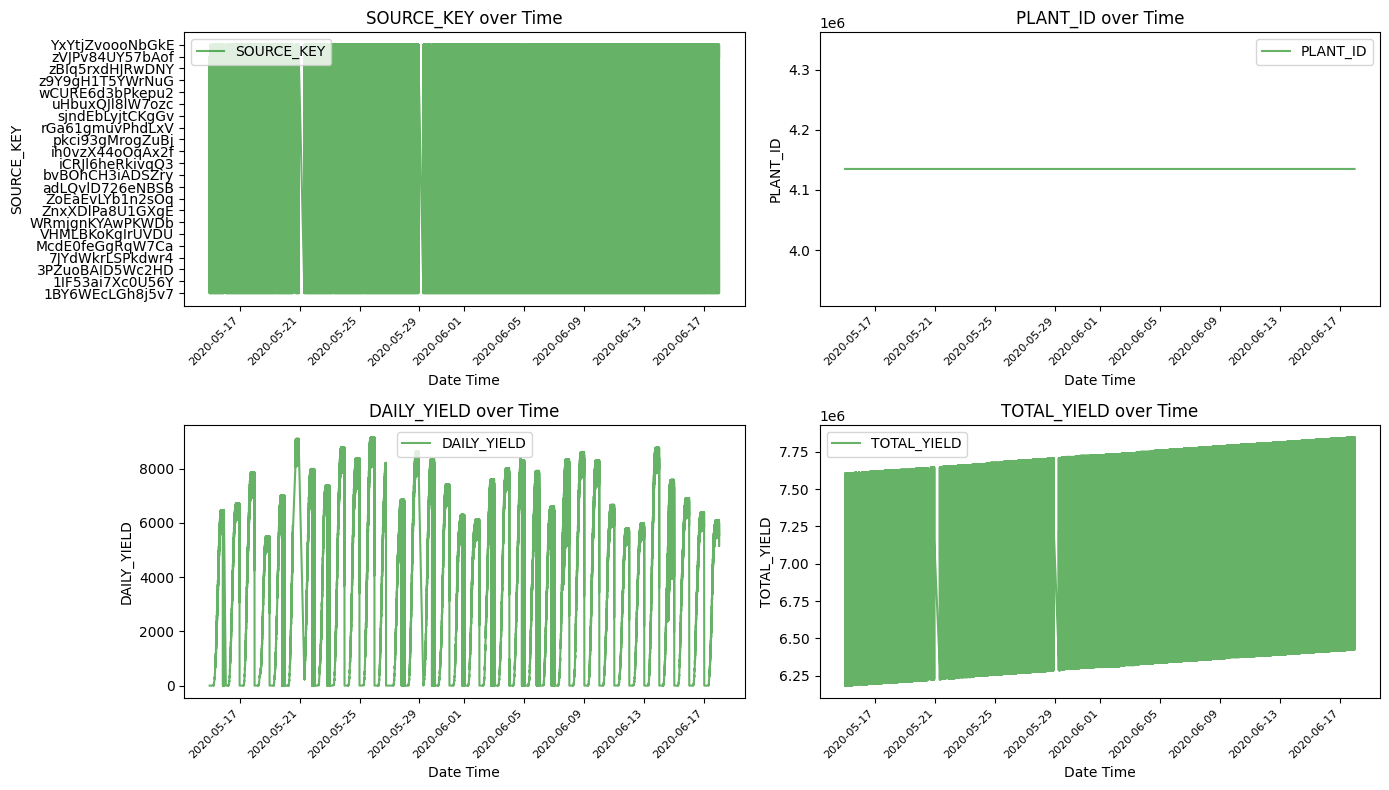

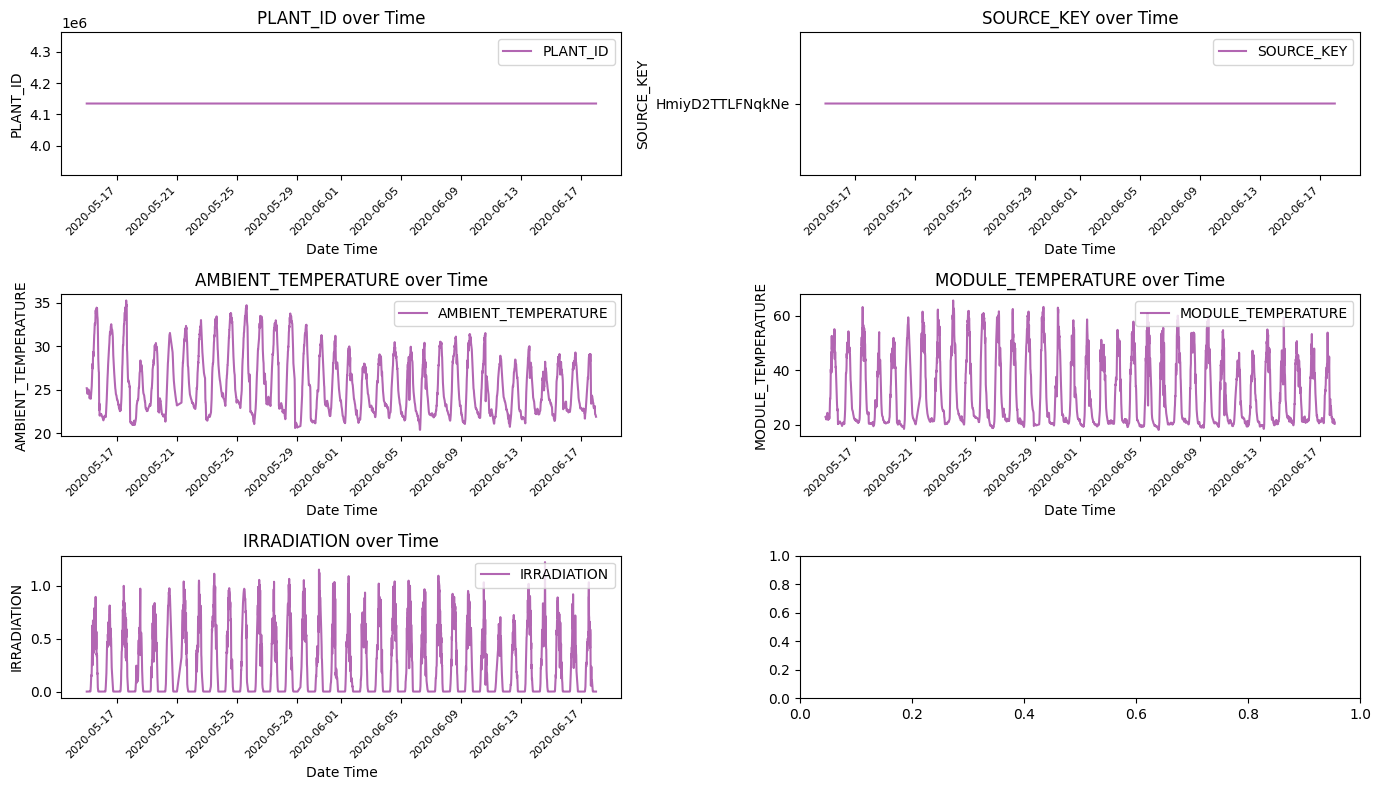


Total Yield per Source Key over Time


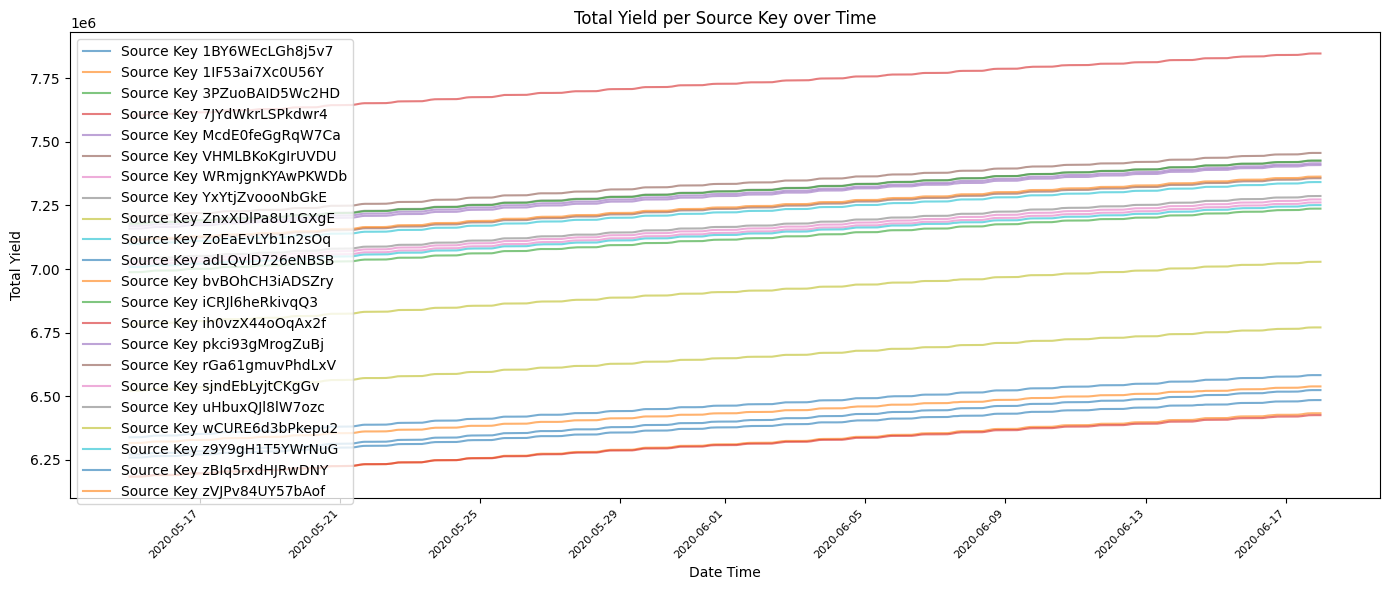


Total Yield and Daily Yield for Source Key 1BY6WEcLGh8j5v7


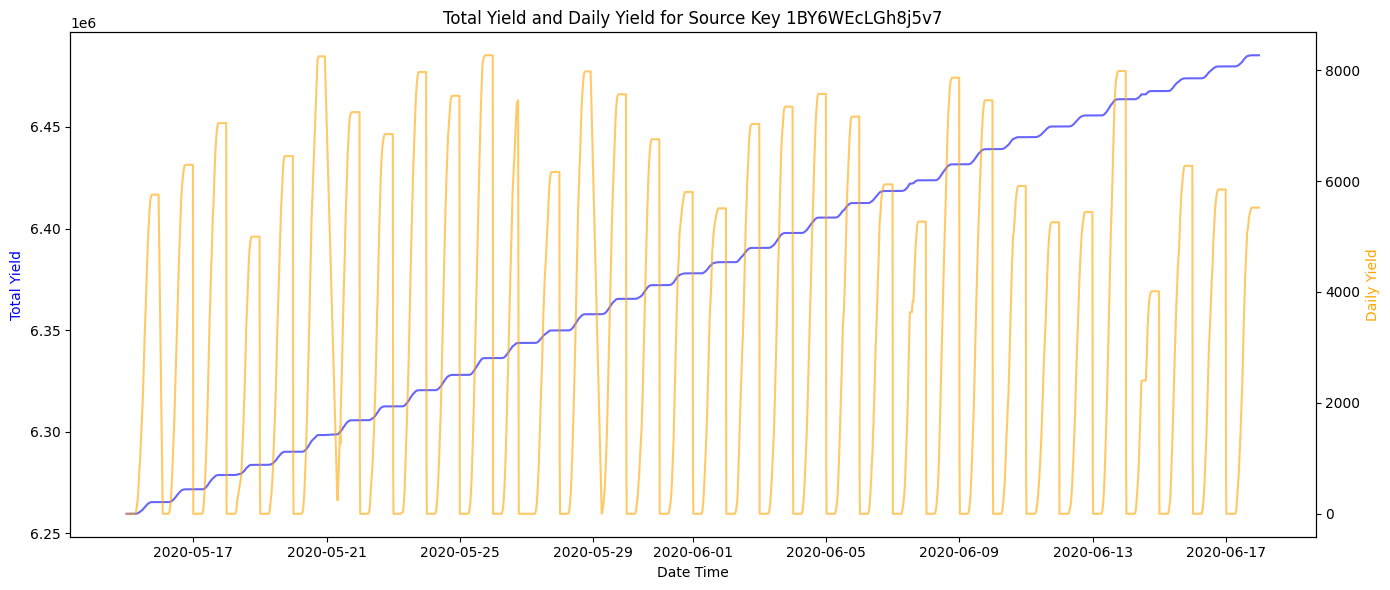

In [ ]:
# Wrong DC power values
plt.plot(generation_data_initial["DATE_TIME"], generation_data_initial["AC_POWER"], label="AC Power", color="blue", alpha=0.6)
plt.plot(generation_data_initial["DATE_TIME"], generation_data_initial["DC_POWER"], label="DC Power", color="orange", alpha=0.6)
plt.ylabel("Power in kWh")
plt.title("AC and DC Power over Time")
plt.legend()
plt.gcf().set_size_inches(14, 6)
plt.show()

# Plot all other columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
other_columns = ["SOURCE_KEY", "PLANT_ID", "DAILY_YIELD", "TOTAL_YIELD"]
for ax, column in zip(axes.flatten(), other_columns):
    ax.plot(generation_data_initial["DATE_TIME"], generation_data_initial[column], label=column, color="green", alpha=0.6)
    ax.set_xlabel("Date Time")
    ax.set_ylabel(column)
    ax.set_title(f"{column} over Time")
    ax.legend()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
plt.tight_layout()
plt.show()

# Weather data plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
weather_columns = ["PLANT_ID", "SOURCE_KEY", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]
for ax, column in zip(axes.flatten(), weather_columns):
    ax.plot(weather_data_initial["DATE_TIME"], weather_data_initial[column], label=column, color="purple", alpha=0.6)
    ax.set_xlabel("Date Time")
    ax.set_ylabel(column)
    ax.set_title(f"{column} over Time")
    ax.legend()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
plt.tight_layout()
plt.show()

# Inspection if total yield makes sense
plt.figure(figsize=(14, 6))
for source_key, group in generation_data_initial.groupby("SOURCE_KEY"):
    plt.plot(group["DATE_TIME"], group["TOTAL_YIELD"], label=f"Source Key {source_key}", alpha=0.6)
plt.xlabel("Date Time")
plt.ylabel("Total Yield in kWh")
plt.title("Total Yield per Source Key over Time")
plt.legend()
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.tight_layout()
plt.show()

# Inspection of Total Yield and Daily Yield for one source key
# Just took a random source key to visualize
source_key = "1BY6WEcLGh8j5v7"
subset = generation_data_initial[generation_data_initial["SOURCE_KEY"] == source_key]
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(subset["DATE_TIME"], subset["TOTAL_YIELD"], label="Total Yield in kWh", color="blue", alpha=0.6)
ax1.set_xlabel("Date Time")
ax1.set_ylabel("Total Yield in kWh", color="blue")
ax2 = ax1.twinx()
ax2.plot(subset["DATE_TIME"], subset["DAILY_YIELD"], label="Daily Yield in kWh", color="orange", alpha=0.6)
ax2.set_ylabel("Daily Yield in kWh", color="orange")
plt.title(f"Total Yield and Daily Yield for Source Key {source_key}")
fig.tight_layout()
plt.show()

# After visually inspecting for outliers I couldn't find any

## Data preprocessing pipeline (cleaning steps, handling missing data, outliers strategy, resampling or alignment if needed, feature engineering basics) (20 points)

In [ ]:
# Chosen the Source Key Inverter with the most data samples
top_key = "bvBOhCH3iADSZry"

donor_cols = ["AC_POWER", "DC_POWER"]
timestamp_donors = (
    generation_data_initial.groupby("DATE_TIME")[donor_cols]
    .median()
    .add_suffix("_donor")
    .reset_index()
)

# Removing source key and keeping only one source key and its values. For missing values
# Fill from the median of all inverters at that timestamp
generation_data_initial = generation_data_initial[generation_data_initial["SOURCE_KEY"] == top_key].copy()
generation_data_initial = generation_data_initial.merge(timestamp_donors, on="DATE_TIME", how="left")

for col in donor_cols:
    donor_col = f"{col}_donor"
    fill_mask = generation_data_initial[col].isna()
    generation_data_initial.loc[fill_mask, col] = generation_data_initial.loc[fill_mask, donor_col]
    generation_data_initial.drop(columns=[donor_col], inplace=True)

In [ ]:
# Incosistent units of DC power does not match AC power at factor 10
generation_data_fix = generation_data_initial.copy()
generation_data_fix["DC_POWER"] = generation_data_initial["DC_POWER"] / 10

# We can remove the plant id column as it is always the same for both datasets
generation_data_fix = generation_data_fix.drop(columns=["PLANT_ID"])
weather_data_initial = weather_data_initial.drop(columns=["PLANT_ID"])

# Dropping total yield as it is only for different source keys, will be recalculated further down
generation_data_fix = generation_data_fix.drop(columns=["TOTAL_YIELD"])

In [ ]:
generation_data_clean = generation_data_fix.copy()

# IQR method for outlier detection for the generation data per source key
# Have to do per source key, otherwise IRQ will be skewed
cols_to_clean_generation = ["DC_POWER", "AC_POWER"]
for col in cols_to_clean_generation:
    # Q1 and Q3 per SOURCE_KEY
    q1_per_group = generation_data_clean.groupby("SOURCE_KEY")[col].quantile(0.25)
    q3_per_group = generation_data_clean.groupby("SOURCE_KEY")[col].quantile(0.75)

    # map group quantiles back to rows
    q1_per_row = generation_data_clean["SOURCE_KEY"].map(q1_per_group)
    q3_per_row = generation_data_clean["SOURCE_KEY"].map(q3_per_group)

    # compute IQR and bounds per row
    iqr_per_row = q3_per_row - q1_per_row
    lower_bound = q1_per_row - 1.5 * iqr_per_row
    upper_bound = q3_per_row + 1.5 * iqr_per_row

    # identify outliers and replace with NaN
    before_nulls = generation_data_clean[col].isna().sum()
    invalid_mask = ~((generation_data_clean[col] >= lower_bound) & (generation_data_clean[col] <= upper_bound))
    removed_count = invalid_mask.sum()
    generation_data_clean.loc[invalid_mask, col] = np.nan
    after_nulls = generation_data_clean[col].isna().sum()

    print(f"{col}: removed {removed_count} values (nulls before={before_nulls}, after={after_nulls})")

# IQR method for outlier detection for the weather data
weather_data_clean = weather_data_initial.copy()
cols_to_clean_weather = ["IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]

for col in cols_to_clean_weather:
    # Q1 and Q3
    q1 = weather_data_clean[col].quantile(0.25)
    q3 = weather_data_clean[col].quantile(0.75)

    # compute IQR and bounds
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # identify outliers and replace with NaN
    before_nulls = weather_data_clean[col].isna().sum()
    invalid_mask = ~((weather_data_clean[col] >= lower_bound) & (weather_data_clean[col] <= upper_bound))
    removed_count = invalid_mask.sum()
    weather_data_clean.loc[invalid_mask, col] = np.nan
    after_nulls = weather_data_clean[col].isna().sum()

    print(f"{col}: removed {removed_count} values (nulls before={before_nulls}, after={after_nulls})")

# Drop source key from both datasets (assuming weather data is representative for whole plant)
weather_data_clean = weather_data_clean.drop(columns=["SOURCE_KEY"])
generation_data_clean = generation_data_clean.drop(columns=["SOURCE_KEY"])
generation_data_clean = generation_data_clean.sort_values("DATE_TIME")

# overwrite DAILY_YIELD with plant-wide cumulative AC energy per day
generation_data_clean.drop(columns=["DAILY_YIELD"], inplace=True)

generation_data_clean = generation_data_clean.sort_values("DATE_TIME").reset_index(drop=True)
generation_data_clean["date_only"] = generation_data_clean["DATE_TIME"].dt.normalize()

interval_hours = 0.25  # 15‑minute cadence

# recompute TOTAL_YIELD from the new daily series
ac_energy_step = generation_data_clean["AC_POWER"].fillna(0) * interval_hours
generation_data_clean["DAILY_YIELD"] = ac_energy_step.groupby(generation_data_clean["date_only"]).cumsum()
generation_data_clean["TOTAL_YIELD"] = ac_energy_step.cumsum()
generation_data_clean.drop(columns=["date_only"], inplace=True)

# Merge datasets on DATE_TIME
df_merged = pd.merge_asof(generation_data_clean.sort_values("DATE_TIME"),
                          weather_data_clean.sort_values("DATE_TIME"),
                          on="DATE_TIME",
                          direction="nearest",
                          tolerance=pd.Timedelta("30min"))

df_merged = df_merged.set_index("DATE_TIME").sort_index()

# Fill AMBIENT_TEMPERATURE and MODULE_TEMPERATURE missing values
for col in ["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]:
    na_before = df_merged[col].isna().sum()
    df_merged[col] = df_merged[col].interpolate(method="time", limit=2, limit_direction="both")
    na_after = df_merged[col].isna().sum()
    filled_count = na_before - na_after
    print(f"{col}: filled {filled_count} (na before={na_before}, na after={na_after})")

# Fill IRRADIATION missing values
na_before = df_merged["IRRADIATION"].isna().sum()
src = weather_data_clean if "weather_data_clean" in globals() else weather_data_initial
hourly_med = src.assign(hour=src["DATE_TIME"].dt.hour).groupby("hour")["IRRADIATION"].median()
df_merged["hour"] = df_merged.index.hour
df_merged["IRRADIATION"] = df_merged["IRRADIATION"].fillna(df_merged["hour"].map(hourly_med))
night = list(range(0,6)) + list(range(20,24))
df_merged.loc[df_merged.index.hour.isin(night) & df_merged["IRRADIATION"].isna(), "IRRADIATION"] = 0.0
df_merged["IRRADIATION"] = df_merged["IRRADIATION"].interpolate(method="time", limit=96, limit_direction="both")
df_merged["IRRADIATION"] = df_merged["IRRADIATION"].fillna(src["IRRADIATION"].median())
print("IRRADIATION filled:", na_before - df_merged["IRRADIATION"].isna().sum(), "remaining NaN:", df_merged["IRRADIATION"].isna().sum())
df_merged.drop(columns=["hour"], inplace=True, errors="ignore")

df_merged = df_merged.reset_index()
print("\nFinal merged dataset overview:")
print_overview(df_merged)

DC_POWER: removed 0 values (nulls before=0, after=0)
AC_POWER: removed 0 values (nulls before=0, after=0)
IRRADIATION: removed 2 values (nulls before=0, after=2)
AMBIENT_TEMPERATURE: removed 0 values (nulls before=0, after=0)
MODULE_TEMPERATURE: removed 0 values (nulls before=0, after=0)
AMBIENT_TEMPERATURE: filled 0 (na before=0, na after=0)
MODULE_TEMPERATURE: filled 0 (na before=0, na after=0)
IRRADIATION filled: 2 remaining NaN: 0

Final merged dataset overview:
Shape: (3155, 9)

Columns and data types:
DATE_TIME              datetime64[ns]
DC_POWER                      float64
AC_POWER                      float64
HOUR                            int32
DAILY_YIELD                   float64
TOTAL_YIELD                   float64
AMBIENT_TEMPERATURE           float64
MODULE_TEMPERATURE            float64
IRRADIATION                   float64
dtype: object

Time range: 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Sampling median: 0 days 00:15:00
Sampling rate (minutes): 15.0

Missingness

,missing_count,missing_percent
DATE_TIME,0,0.0
DC_POWER,0,0.0
AC_POWER,0,0.0
HOUR,0,0.0
DAILY_YIELD,0,0.0
TOTAL_YIELD,0,0.0
AMBIENT_TEMPERATURE,0,0.0
MODULE_TEMPERATURE,0,0.0
IRRADIATION,0,0.0




Large time gaps (greater than expected sampling rate):


,DATE_TIME,TIME_DIFF
93,2020-05-16 02:00:00,0 days 03:00:00
420,2020-05-19 12:30:00,0 days 01:00:00
520,2020-05-20 17:30:00,0 days 04:15:00
542,2020-05-21 07:45:00,0 days 09:00:00
724,2020-05-23 06:45:00,0 days 01:45:00
784,2020-05-23 22:00:00,0 days 00:30:00
910,2020-05-25 06:15:00,0 days 01:00:00
1263,2020-05-29 06:15:00,0 days 08:00:00
1774,2020-06-03 14:15:00,0 days 00:30:00
3086,2020-06-17 06:45:00,0 days 00:45:00


## Preprocessed vs original comparison (before/after visuals plus commentary on what changed and why) (10 points)

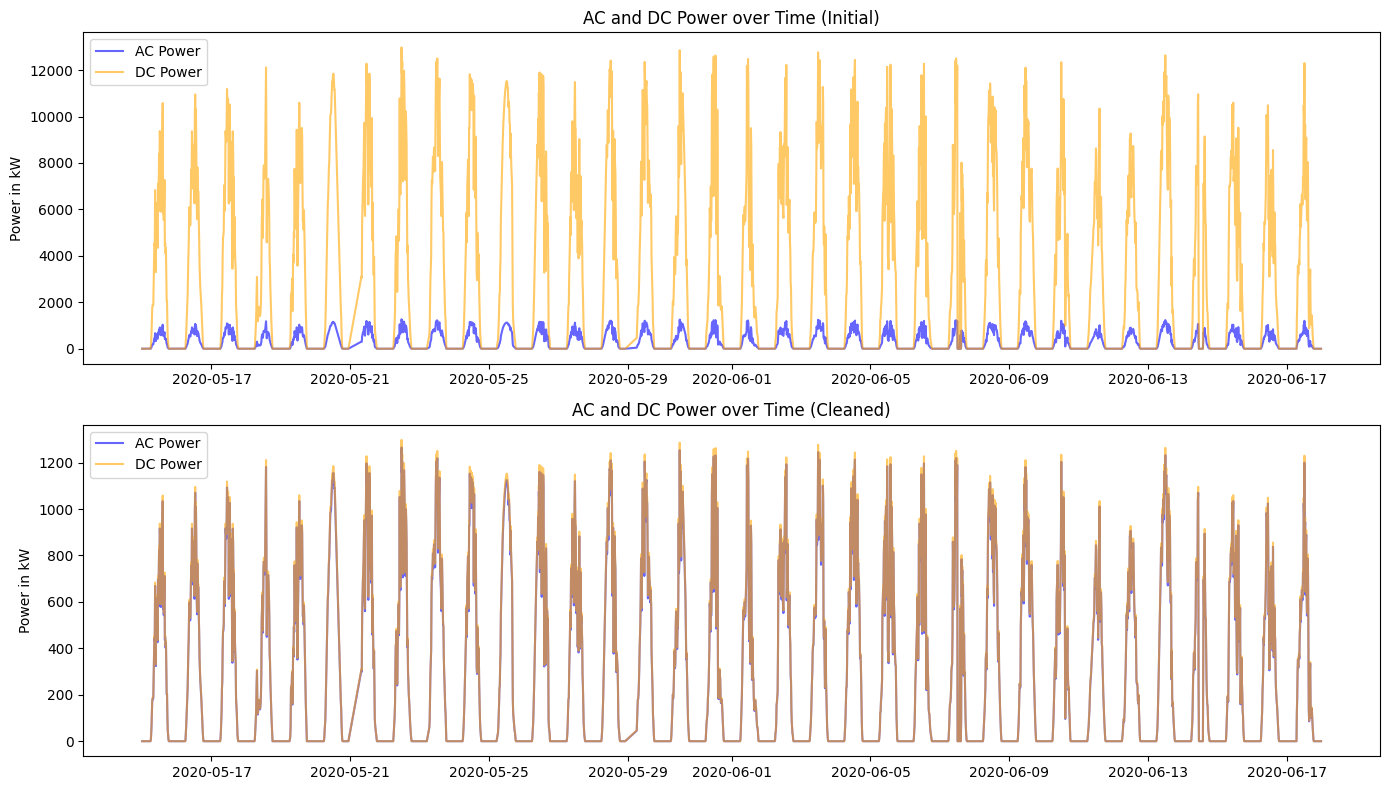

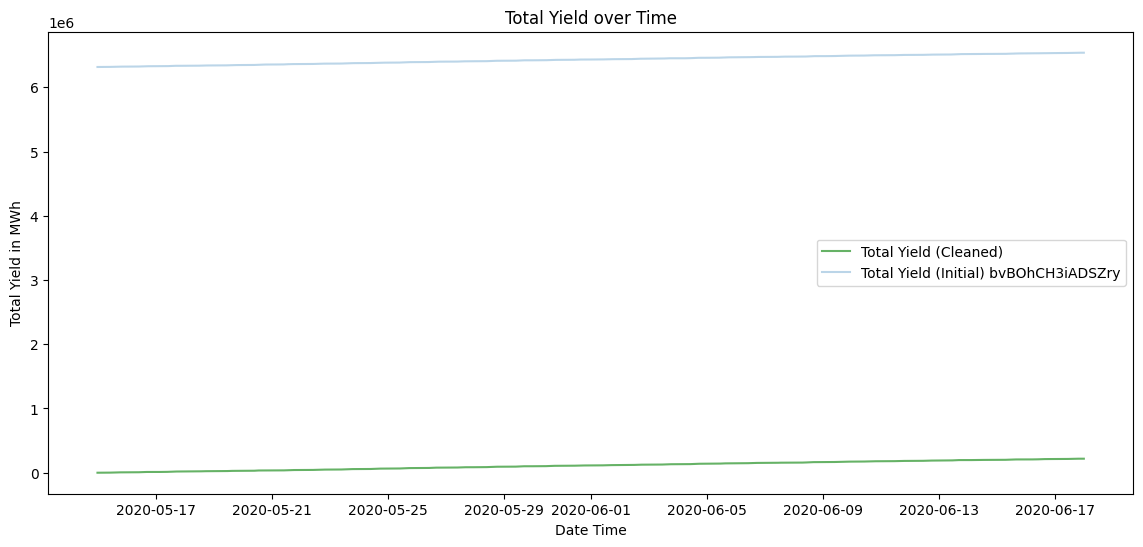

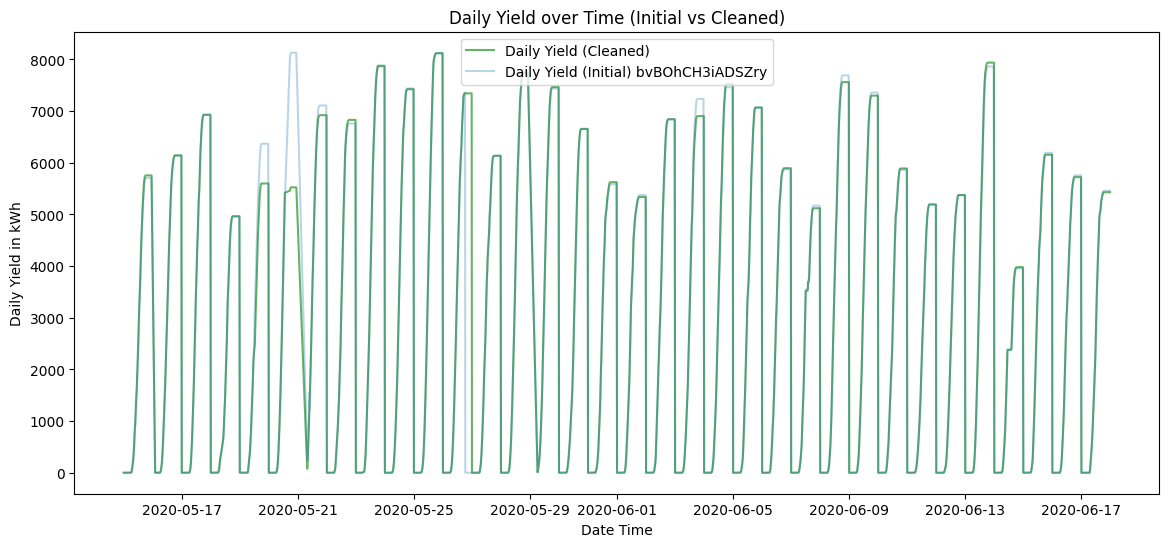

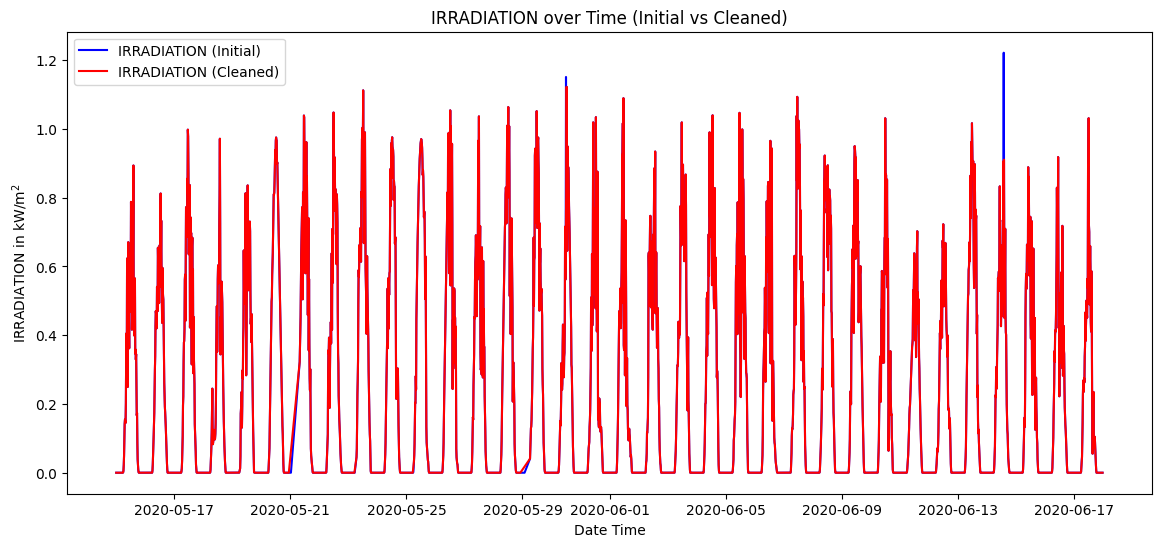

In [ ]:
# What changed and why:
# DC power calculation fixed to match AC power scale
tmin = generation_data_initial["DATE_TIME"].min()
tmax = generation_data_initial["DATE_TIME"].max()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))

axes[0].plot(generation_data_initial["DATE_TIME"], generation_data_initial["AC_POWER"], label="AC Power", color="blue", alpha=0.6)
axes[0].plot(generation_data_initial["DATE_TIME"], generation_data_initial["DC_POWER"], label="DC Power", color="orange", alpha=0.6)
axes[0].set_ylabel("Power in kW")
axes[0].set_title("AC and DC Power over Time (Initial)")
axes[0].legend()

axes[1].plot(generation_data_clean["DATE_TIME"], generation_data_clean["AC_POWER"], label="AC Power", color="blue", alpha=0.6)
axes[1].plot(generation_data_clean["DATE_TIME"], generation_data_clean["DC_POWER"], label="DC Power", color="orange", alpha=0.6)
axes[1].set_ylabel("Power in kW")
axes[1].set_title("AC and DC Power over Time (Cleaned)")
axes[1].legend()
plt.tight_layout()
plt.show()

# Total yield recalculated from daily yield
plt.figure(figsize=(14, 6))
plt.plot(generation_data_clean["DATE_TIME"], generation_data_clean["TOTAL_YIELD"], label="Total Yield (Cleaned)", color="green", alpha=0.6)
for source_key, group in generation_data_initial.groupby("SOURCE_KEY"):
    plt.plot(group["DATE_TIME"], group["TOTAL_YIELD"], label=f"Total Yield (Initial) {source_key}", alpha=0.3)
plt.xlabel("Date Time")
plt.ylabel("Total Yield in MWh")
plt.title("Total Yield over Time")
plt.legend()
plt.show()

# Daily yield recalculated for only one source key
plt.figure(figsize=(14, 6))
plt.plot(generation_data_clean["DATE_TIME"], generation_data_clean["DAILY_YIELD"], label="Daily Yield (Cleaned)", color="green", alpha=0.6)
for source_key, group in generation_data_initial.groupby("SOURCE_KEY"):
    plt.plot(group["DATE_TIME"], group["DAILY_YIELD"], label=f"Daily Yield (Initial) {source_key}", alpha=0.3)
plt.xlabel("Date Time")
plt.ylabel("Daily Yield in kWh")
plt.title("Daily Yield over Time (Initial vs Cleaned)")
plt.legend()
plt.show()

# Here have been 2 outliers removed and some points have been interpolated
plt.figure(figsize=(14, 6))
plt.plot(weather_data_initial["DATE_TIME"], weather_data_initial["IRRADIATION"], label="IRRADIATION (Initial)", color="blue")
plt.plot(df_merged["DATE_TIME"], df_merged["IRRADIATION"], label="IRRADIATION (Cleaned)", color="red")
plt.xlabel("Date Time")
plt.ylabel("IRRADIATION in kW/m$^2$")
plt.title("IRRADIATION over Time (Initial vs Cleaned)")
plt.legend()
plt.show()

# Plant ID removed - nothing to show visually
# I assume the weather data is representative for the whole plant - nothing to show

# 2.2 B. Visualization and Exploratory Data Analysis (55 points)

## Time-series visualizations (raw, smoothed, rolling mean or windowed views) (10 points)

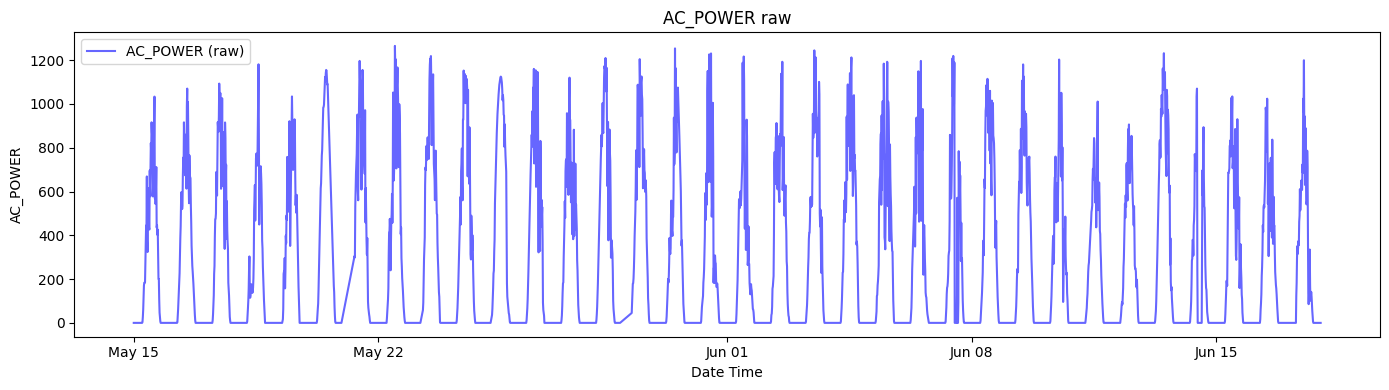

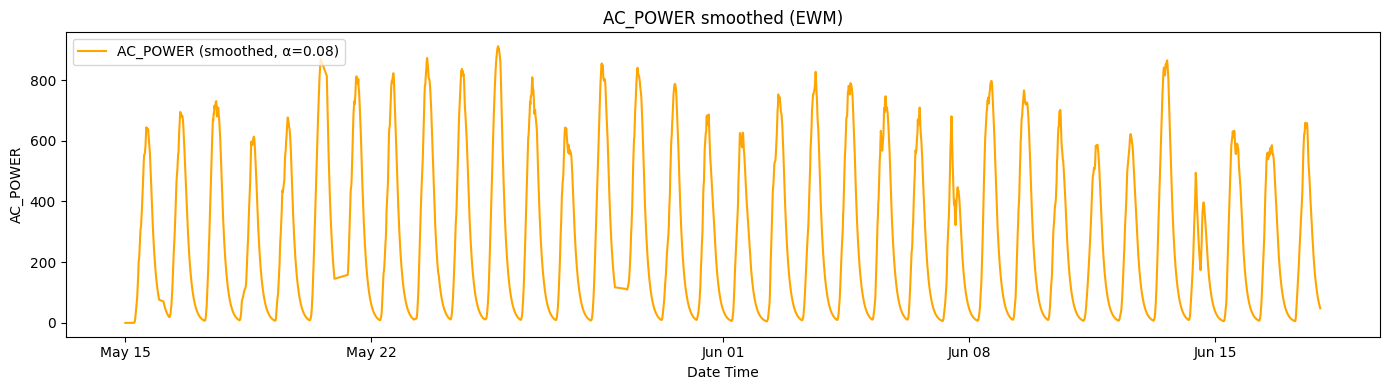

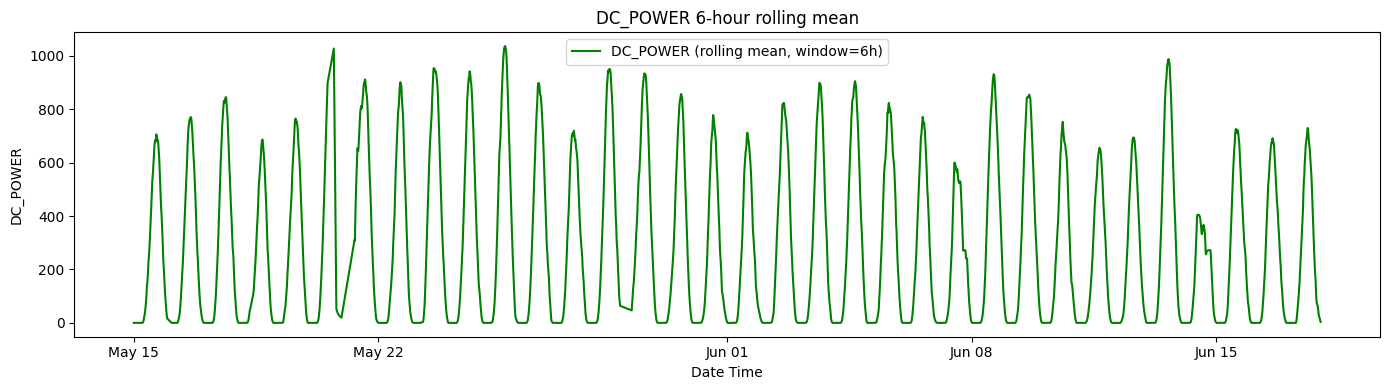

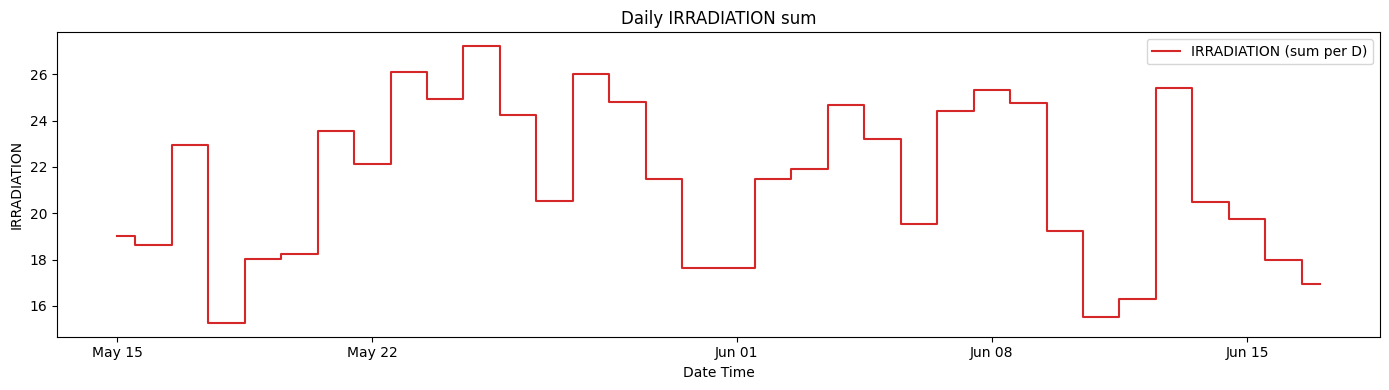

In [ ]:
def plot_raw_series(df, column, ax=None, color="C0", label=None, alpha=0.6):
    ax = ax or plt.gca()
    label = label or f"{column} (raw)"
    ax.plot(df["DATE_TIME"], df[column], color=color, alpha=alpha, label=label)
    ax.set_xlabel("Date Time")
    ax.set_ylabel(column)
    ax.legend()

def plot_smoothed_series(df, column, alpha=0.2, ax=None, color="C1", label=None):
    ax = ax or plt.gca()
    label = label or f"{column} (smoothed, α={alpha})"
    series = df.set_index("DATE_TIME")[column].ewm(alpha=alpha, adjust=False).mean()
    ax.plot(series.index, series.values, color=color, label=label)
    ax.set_xlabel("Date Time")
    ax.set_ylabel(column)
    ax.legend()

def plot_rolling_mean(df, column, window="6h", ax=None, color="C2", label=None):
    ax = ax or plt.gca()
    label = label or f"{column} (rolling mean, window={window})"
    series = df.set_index("DATE_TIME")[column].rolling(window=window, min_periods=1).mean()
    ax.plot(series.index, series.values, color=color, label=label)
    ax.set_xlabel("Date Time")
    ax.set_ylabel(column)
    ax.legend()

def format_date_axis(ax, fmt="%b %d"):
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=8))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

def plot_windowed_view(df, column, freq="D", agg="mean", ax=None, color="C3", label=None):
    ax = ax or plt.gca()
    label = label or f"{column} ({agg} per {freq})"
    windowed = df.set_index("DATE_TIME")[column].resample(freq).agg(agg)
    ax.step(windowed.index, windowed.values, where="mid", color=color, label=label)
    ax.set_xlabel("Date Time")
    ax.set_ylabel(column)
    ax.legend()

# Used every function once
fig, ax = plt.subplots(figsize=(14, 4))
plot_raw_series(generation_data_clean, "AC_POWER", ax=ax, color="blue")
format_date_axis(ax)
ax.set_title("AC_POWER raw")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 4))
plot_smoothed_series(generation_data_clean, "AC_POWER", alpha=0.08, ax=ax, color="orange")
format_date_axis(ax)
ax.set_title("AC_POWER smoothed (EWM)")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 4))
plot_rolling_mean(generation_data_clean, "DC_POWER", window="6h", ax=ax, color="green")
format_date_axis(ax)
ax.set_title("DC_POWER 6-hour rolling mean")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 4))
plot_windowed_view(df_merged, "IRRADIATION", freq="D", agg="sum", ax=ax, color="tab:red")
format_date_axis(ax)
ax.set_title("Daily IRRADIATION sum")
plt.tight_layout()
plt.show()

## Distribution analysis with histograms and density style plots where applicable (10 points)

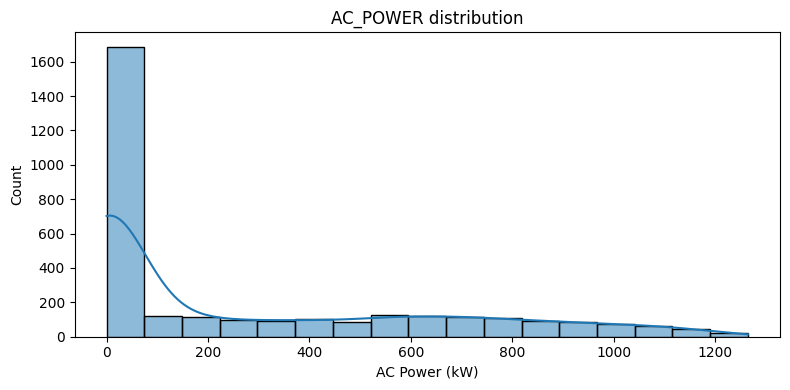

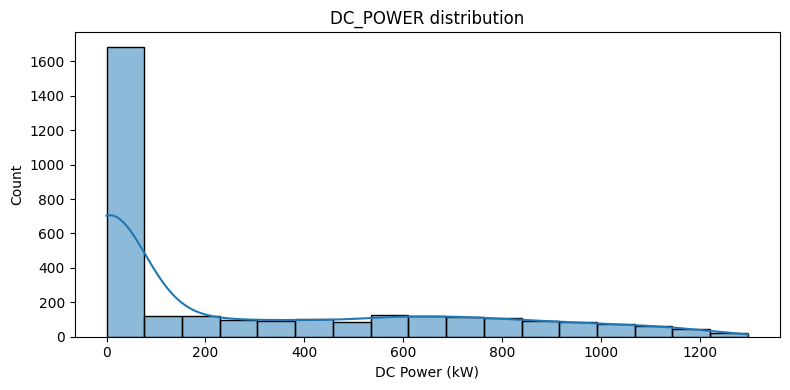

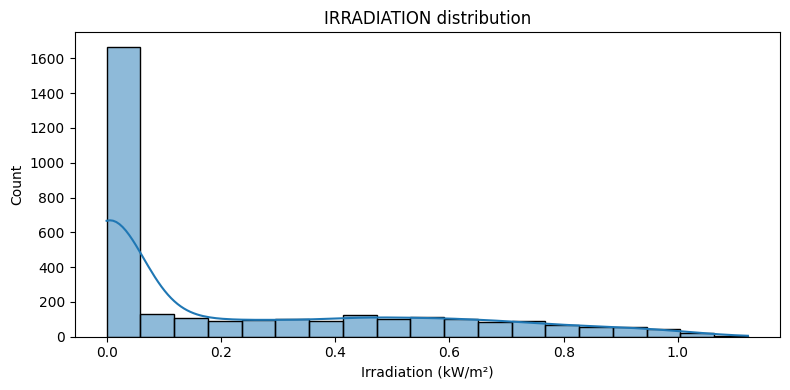

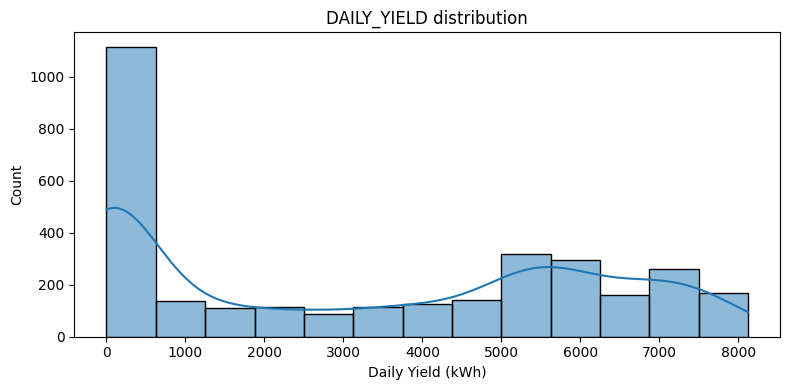

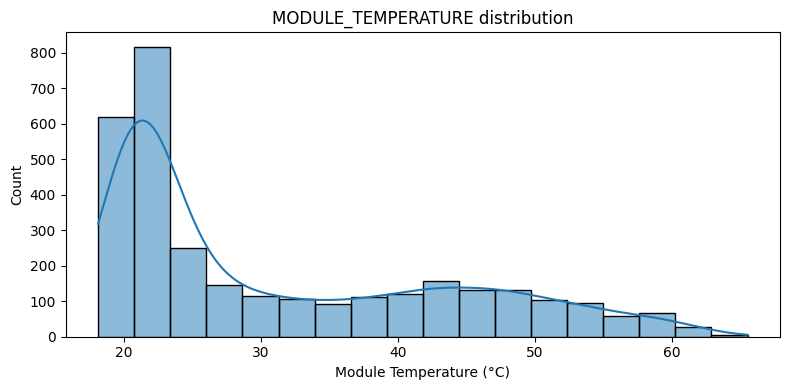

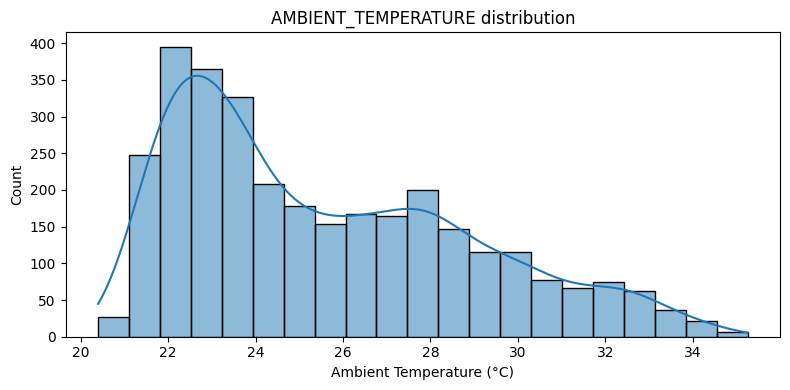

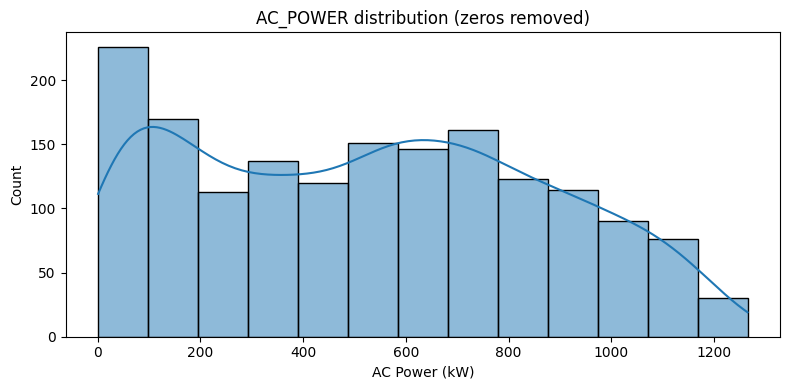

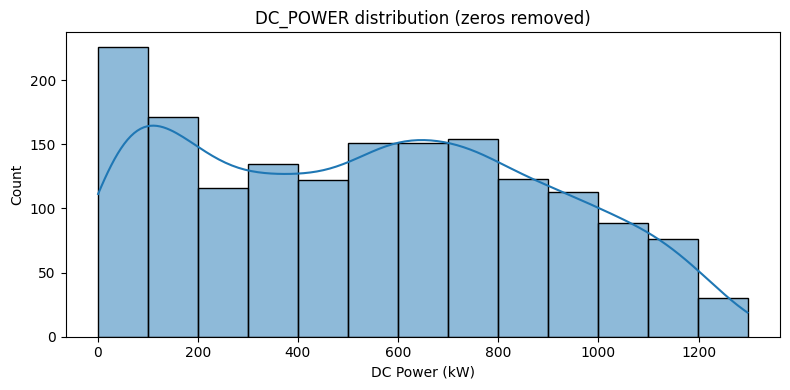

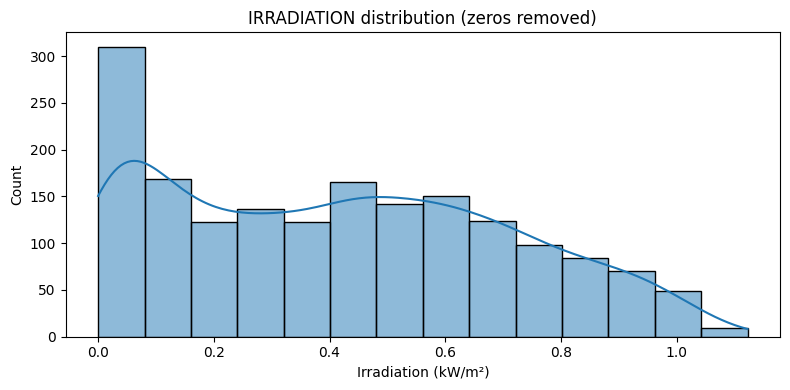

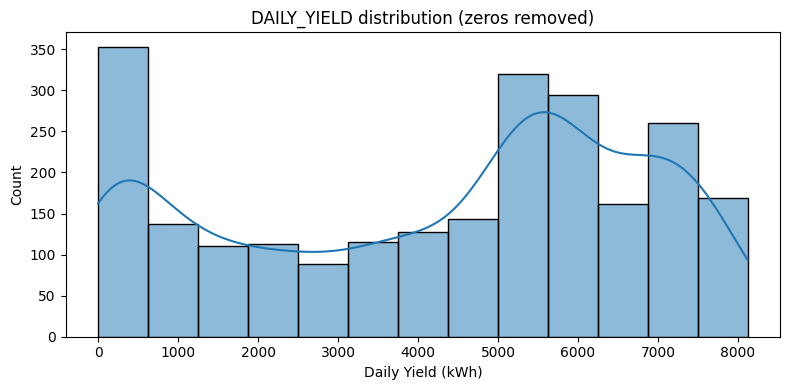

In [ ]:
feature_meta = {
    "AC_POWER": ("AC Power (kW)", "tab:blue"),
    "DC_POWER": ("DC Power (kW)", "tab:blue"),
    "IRRADIATION": ("Irradiation (kW/m²)", "tab:blue"),
    "DAILY_YIELD": ("Daily Yield (kWh)", "tab:blue"),
    "MODULE_TEMPERATURE": ("Module Temperature (°C)", "tab:blue"),
    "AMBIENT_TEMPERATURE": ("Ambient Temperature (°C)", "tab:blue"),
}

for col, (label, color) in feature_meta.items():
    plt.figure(figsize=(8, 4))
    sns.histplot(df_merged[col].dropna(), kde=True, color=color)
    plt.title(f"{col} distribution")
    plt.xlabel(label)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

zero_filtered = ["AC_POWER", "DC_POWER", "IRRADIATION", "DAILY_YIELD"]
for col in zero_filtered:
    label, color = feature_meta[col]
    plt.figure(figsize=(8, 4))
    sns.histplot(df_merged.loc[df_merged[col] != 0, col].dropna(), kde=True, color=color)
    plt.title(f"{col} distribution (zeros removed)")
    plt.xlabel(label)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Removed Total yield as it does not make sense just incrementing value

## Correlation analysis and heatmaps (Pearson and at least one alternative such as Spearman, with short interpretation) (10 points)

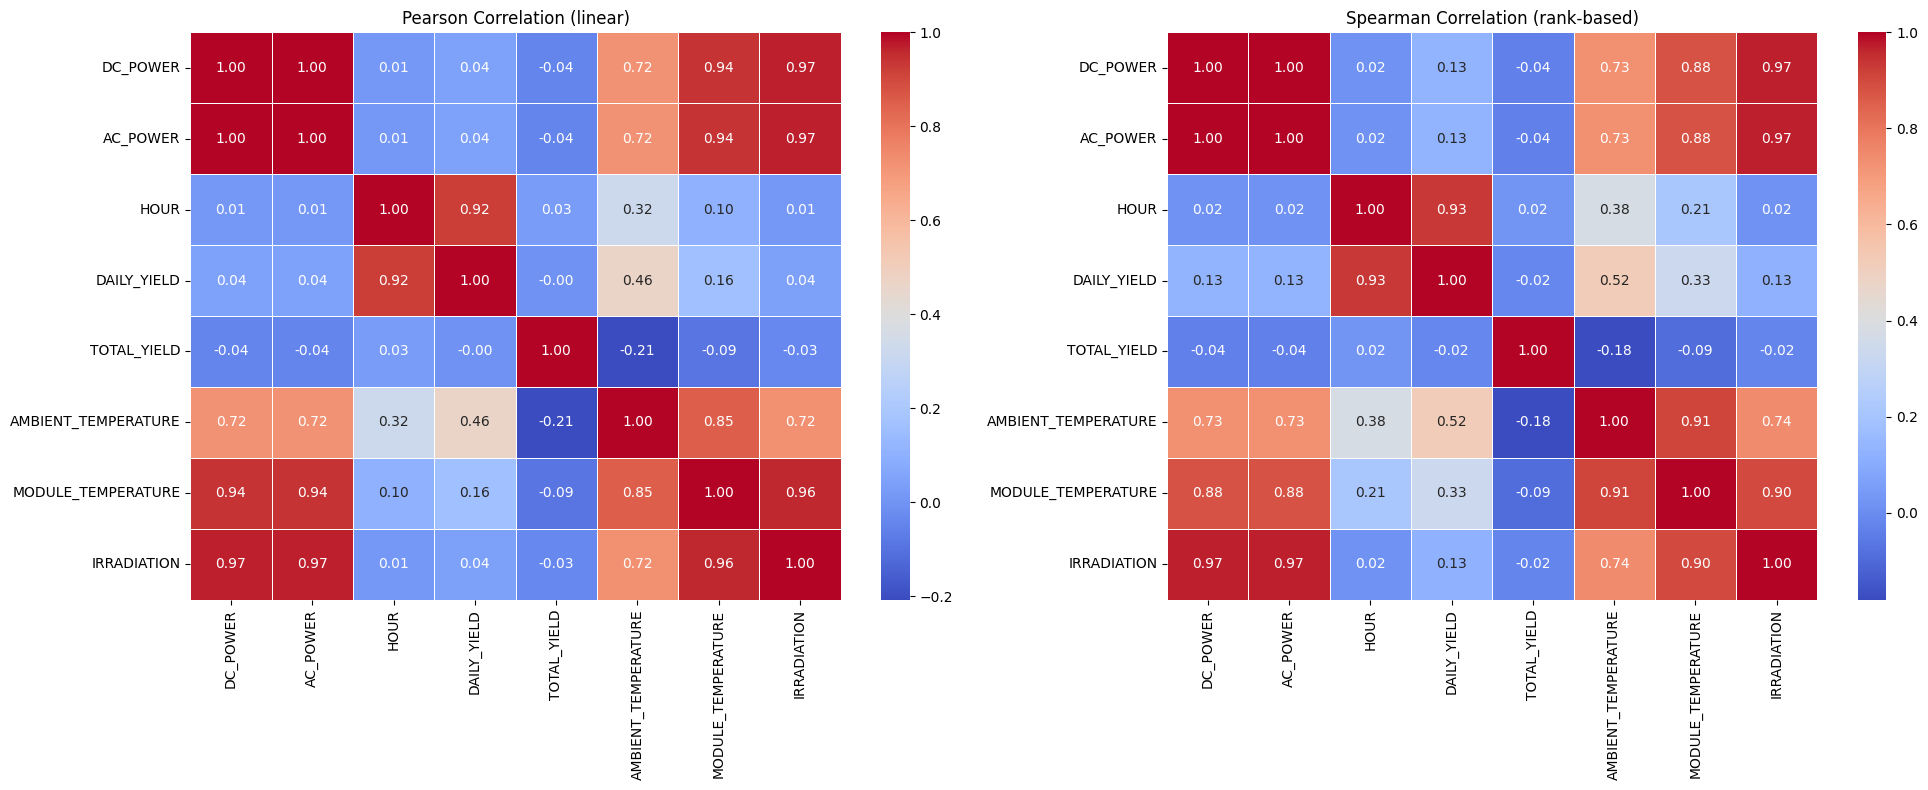

In [132]:
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns
corr_pearson = df_merged[numeric_cols].corr(method="pearson")
corr_spearman = df_merged[numeric_cols].corr(method="spearman")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, ax=axes[0])
axes[0].set_title("Pearson Correlation (linear)")
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, ax=axes[1])
axes[1].set_title("Spearman Correlation (rank-based)")
plt.tight_layout()
plt.show()

# Hard but the only noteable difference: ac/dc power to daily yield
# Pearson stays near zero because the day/night plateaus kill linear slope
# Spearman is higher because sunny hours outrank night, so it sees more sun -> daily yield

## Daily or periodic pattern analysis (day-of-week, hour-of-day, seasonality indicators, or test-cycle patterns) (15 points)

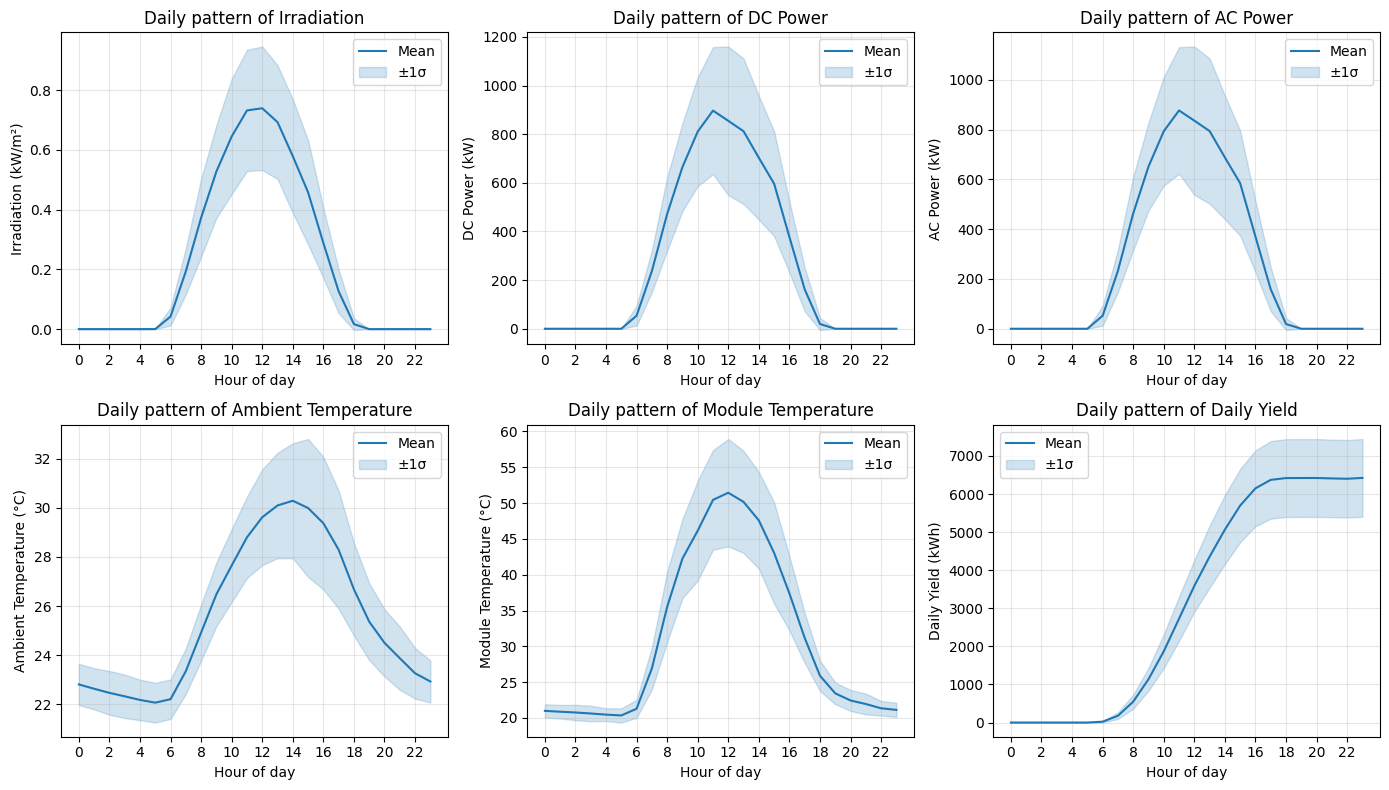

In [133]:
# Daily / periodic pattern analysis
def plot_daily_pattern(df, column, ax, y_label, title):
    hourly = df[["DATE_TIME", column]].dropna().copy()
    hourly["HOUR"] = hourly["DATE_TIME"].dt.hour
    grouped = hourly.groupby("HOUR")[column]
    mean = grouped.mean()
    std = grouped.std()
    ax.plot(mean.index, mean.values, label="Mean", color="tab:blue")
    ax.fill_between(mean.index, mean - std, mean + std, color="tab:blue", alpha=0.2, label="±1σ")
    ax.set_title(title)
    ax.set_xlabel("Hour of day")
    ax.set_ylabel(y_label)
    ax.set_xticks(range(0, 24, 2))
    ax.grid(alpha=0.3)
    ax.legend()

daily_features = [
    ("IRRADIATION", "Irradiation (kW/m²)", "Daily pattern of Irradiation"),
    ("DC_POWER", "DC Power (kW)", "Daily pattern of DC Power"),
    ("AC_POWER", "AC Power (kW)", "Daily pattern of AC Power"),
    ("AMBIENT_TEMPERATURE", "Ambient Temperature (°C)", "Daily pattern of Ambient Temperature"),
    ("MODULE_TEMPERATURE", "Module Temperature (°C)", "Daily pattern of Module Temperature"),
    ("DAILY_YIELD", "Daily Yield (kWh)", "Daily pattern of Daily Yield"),
]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ax, (col, ylabel, title) in zip(axes.flatten(), daily_features):
    plot_daily_pattern(df_merged, col, ax, ylabel, title)

plt.tight_layout()
plt.show()

## Summary of observed patterns as short check statements (similar to True/False style) with evidence (10 points)

Irradiation peaks between 12:00 and 15:00 daily - True
Evidence: The daily pattern plot for IRRADIATION shows a clear peak during these hours consistently across the dataset.

Both DC and AC Power curves follow the irradiation peak, confirming higher sunlight drives higher output - True
Evidence: The daily pattern plots for DC_POWER and AC_POWER both show peaks that align closely with the IRRADIATION peak, indicating a direct relationship between sunlight intensity and power generation.

Ambient Temperature starts rising at about 5:00 and 6:00 - True
Evidence: The daily pattern plot for AMBIENT_TEMPERATURE shows the return point for temperature increase around these hours.

1 Sigma of the daily yield is about 2000kWh - True
Evidence: The statistical summary of DAILY_YIELD indicates a standard deviation (1 Sigma) close to 2000 kWh, confirming this observation.

# 2.3 C. Probability and Event Analysis (45 points)

## Threshold-based probability estimation for events (define event, justify threshold, compute empirical probability) (15 points)

In [134]:
def threshold_probability(df, column, threshold):
    return (df[column] > threshold).mean()

event_col = "AC_POWER"
threshold_kw = df_merged[event_col].quantile(0.90)
p_high_ac = threshold_probability(generation_data_clean, event_col, threshold_kw)
print(f"P({event_col} > {threshold_kw:,.0f}) = {p_high_ac:.2%}")

event_col = "IRRADIATION"
threshold_IR = df_merged[event_col].quantile(0.80)
p_high_ir = threshold_probability(df_merged, event_col, threshold_IR)
print(f"P({event_col} > {threshold_IR}) = {p_high_ir:.2%}")

P(AC_POWER > 873) = 10.02%
P(IRRADIATION > 0.5364255782666665) = 20.00%


## Cross tabulation analysis for two variables (10 points)

ModuleTemp_Bin   <20°C  20-30°C  30-40°C  40-50°C  >50°C
Irradiation_Bin                                         
Zero               221     1181        0        0      0
Very Low            31      408      103        2      0
Low                  0       51      206       59      1
Medium               0        0       90      271     24
High                 0        0        6      170    116
Very High            0        0        0       21    194


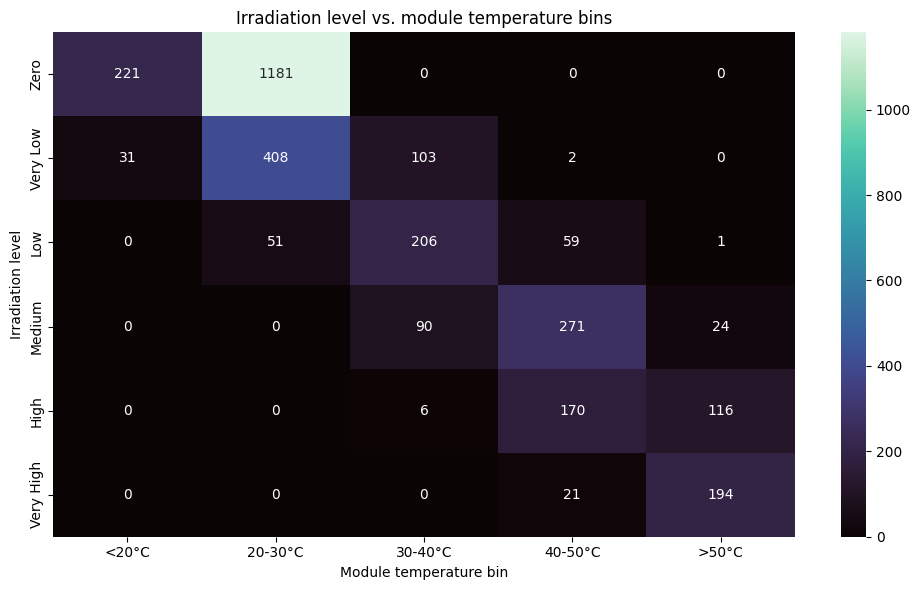

In [135]:
irr_bins = [-0.1, 0.0, 0.2, 0.4, 0.6, 0.8, df_merged["IRRADIATION"].max()]
irr_labels = ["Zero", "Very Low", "Low", "Medium", "High", "Very High"]
temp_bins = [df_merged["MODULE_TEMPERATURE"].min()-1, 20, 30, 40, 50, df_merged["MODULE_TEMPERATURE"].max()+1]
temp_labels = ["<20°C", "20-30°C", "30-40°C", "40-50°C", ">50°C"]

df_merged["Irradiation_Bin"] = pd.cut(df_merged["IRRADIATION"], bins=irr_bins, labels=irr_labels)
df_merged["ModuleTemp_Bin"] = pd.cut(df_merged["MODULE_TEMPERATURE"], bins=temp_bins, labels=temp_labels)

cross_tab = pd.crosstab(df_merged["Irradiation_Bin"], df_merged["ModuleTemp_Bin"])
print(cross_tab)

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="mako")
plt.title("Irradiation level vs. module temperature bins")
plt.xlabel("Module temperature bin")
plt.ylabel("Irradiation level")
plt.tight_layout()
plt.show()

df_merged.drop(columns=["Irradiation_Bin", "ModuleTemp_Bin"], inplace=True)

## Conditional probability analysis (at least two meaningful conditional relationships) (15points)

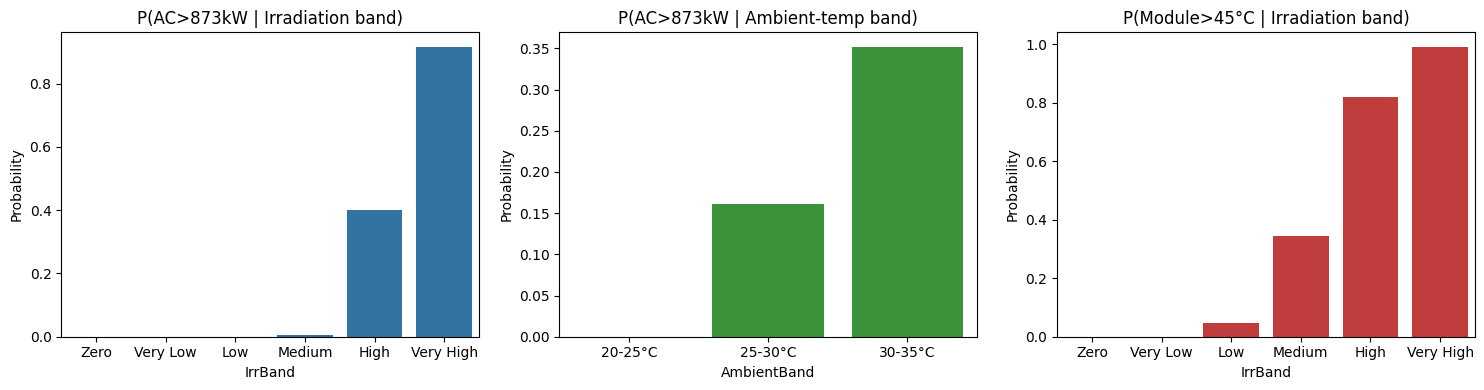

In [136]:
def conditional_probabilities(df, bander, target_mask, label):
    records = []
    for level in df[bander].cat.categories:
        mask = df[bander] == level
        if mask.sum() == 0:
            continue
        records.append({
            bander: level,
            label: (target_mask & mask).sum() / mask.sum()
        })
    return pd.DataFrame(records)

temp_edges = sorted(set([
    df_merged["AMBIENT_TEMPERATURE"].min() - 1,
    15, 20, 25, 30,
    df_merged["AMBIENT_TEMPERATURE"].max() + 1
]))
temp_labels = ["<15°C","15-20°C","20-25°C","25-30°C","30-35°C"][:len(temp_edges)-1]

tmp = df_merged.assign(
    IrrBand=pd.cut(df_merged["IRRADIATION"], bins=irr_bins,
                   labels=["Zero","Very Low","Low","Medium","High","Very High"]),
    AmbientBand=pd.cut(df_merged["AMBIENT_TEMPERATURE"], bins=temp_edges, labels=temp_labels),
    ModuleBand=pd.cut(df_merged["MODULE_TEMPERATURE"],
                      bins=[0,25,35,45,55,70], labels=["<25°C","25-35°C","35-45°C","45-55°C",">55°C"])
)

high_power_threshold = df_merged["AC_POWER"].quantile(0.90)
high_power_label = f"P(AC>{high_power_threshold:.0f}kW)"
high_power_mask = tmp["AC_POWER"] > high_power_threshold
hot_module_mask = tmp["MODULE_TEMPERATURE"] > 45
hot_module_label = "P(Module>45°C)"

prob_power_given_irr = conditional_probabilities(tmp, "IrrBand", high_power_mask, high_power_label)
prob_power_given_ambient = conditional_probabilities(tmp, "AmbientBand", high_power_mask, high_power_label)
prob_hot_module_given_irr = conditional_probabilities(tmp, "IrrBand", hot_module_mask, hot_module_label)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

sns.barplot(data=prob_power_given_irr, x="IrrBand", y=high_power_label, ax=axes[0], color="tab:blue")
axes[0].set_title(f"P(AC>{high_power_threshold:.0f}kW | Irradiation band)")
axes[0].set_ylabel("Probability")

sns.barplot(data=prob_power_given_ambient, x="AmbientBand", y=high_power_label, ax=axes[1], color="tab:green")
axes[1].set_title(f"P(AC>{high_power_threshold:.0f}kW | Ambient-temp band)")
axes[1].set_ylabel("Probability")

sns.barplot(data=prob_hot_module_given_irr, x="IrrBand", y=hot_module_label, ax=axes[2], color="tab:red")
axes[2].set_title("P(Module>45°C | Irradiation band)")
axes[2].set_ylabel("Probability")

plt.tight_layout()
plt.show()

## Summary of observations and limitations (what could bias these estimates, what assumptions were made) (5 points)

Observations:
870kW was chosen as the observed threshold and is nearly maximum output for most inverters. High irradiation bands almost guarantee AC > 870 kW. Ambient temperatures between 25–35 °C keep success probability high. Module overheating only appears in the top irradiation bins.

Limitations/bias:
Assumes one weather sensor represents all inverters. interpolated irradiation and temperature smooths peaks. equal weighting of night and day timestamps drags probabilities down.

# 2.4 D. Statistical Theory Application (30 points)

## Law of Large Numbers demonstration (15 points)

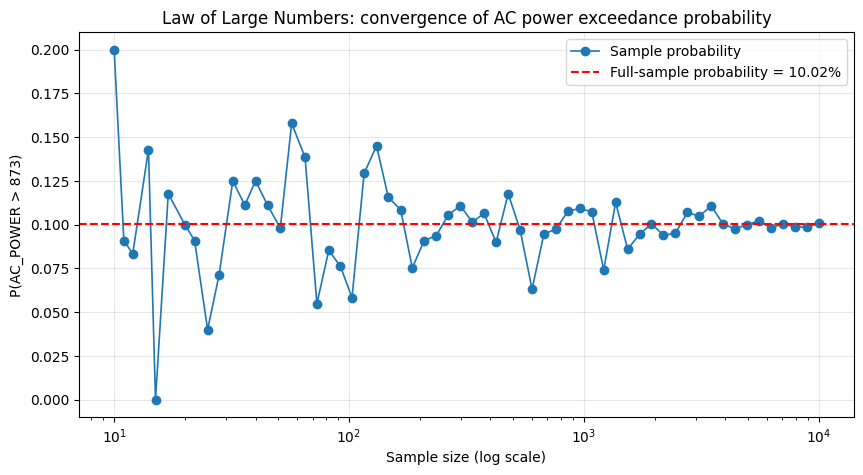

In [137]:
def visualize_lln_probabilities(data, column, threshold=None, n_points=60):
    series = data[column].dropna()
    if threshold is None:
        threshold = series.quantile(0.90)  # ≈8 kW here
    true_prob = (series > threshold).mean()

    sample_sizes = np.unique(np.logspace(1, 4, n_points).astype(int))
    observed_probs = [
        (series.sample(n=n, replace=True) > threshold).mean()
        for n in sample_sizes
    ]

    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, observed_probs, marker="o", linewidth=1.2, label="Sample probability")
    plt.axhline(true_prob, color="red", linestyle="--", label=f"Full-sample probability = {true_prob:.2%}")
    plt.xscale("log")
    plt.xlabel("Sample size (log scale)")
    plt.ylabel(f"P({column} > {threshold:,.0f})")
    plt.title("Law of Large Numbers: convergence of AC power exceedance probability")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

visualize_lln_probabilities(generation_data_clean, "AC_POWER")

## Central Limit Theorem application (sampling distributions, effect of sample size, interpretation) (25 points)

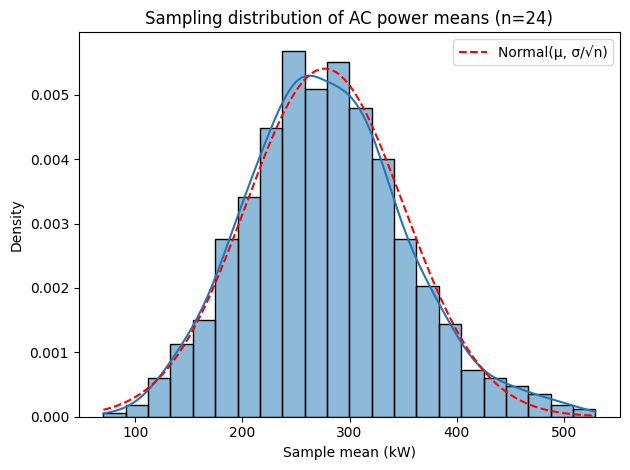

n=24: mean=278.0 vs pop μ=276.8
          std=74.2 vs expected σ/√n=73.8



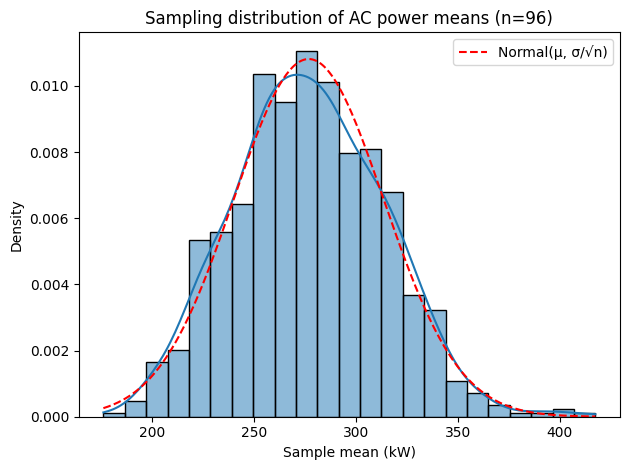

n=96: mean=276.9 vs pop μ=276.8
          std=36.6 vs expected σ/√n=36.9



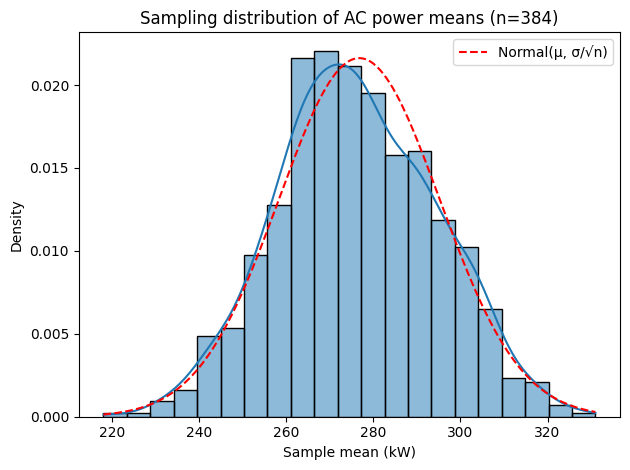

n=384: mean=276.2 vs pop μ=276.8
          std=18.2 vs expected σ/√n=18.4



In [138]:
def simulate_sampling_distribution(population, sample_size, n_samples=1000):
    sample_means = np.array([
        np.mean(np.random.choice(population, size=sample_size))
        for _ in range(n_samples)
    ])
    return sample_means

def plot_sampling_distribution(population, sample_size, n_samples=1000):
    sample_means = simulate_sampling_distribution(population, sample_size, n_samples)
    pop_mean = np.mean(population)
    pop_std = np.std(population, ddof=0)
    theoretical_std = pop_std / np.sqrt(sample_size)

    sns.histplot(sample_means, kde=True, stat="density", color="tab:blue")
    x = np.linspace(sample_means.min(), sample_means.max(), 300)
    plt.plot(x, stats.norm.pdf(x, pop_mean, theoretical_std), "r--", label="Normal(μ, σ/√n)")
    plt.title(f"Sampling distribution of AC power means (n={sample_size})")
    plt.xlabel("Sample mean (kW)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"n={sample_size}: mean={sample_means.mean():.1f} vs pop μ={pop_mean:.1f}")
    print(f"          std={sample_means.std():.1f} vs expected σ/√n={theoretical_std:.1f}\n")

population = generation_data_clean["AC_POWER"].dropna().values
for n in (24, 96, 384):  # ≈1h, 4h, 16h of 15-min samples
    plot_sampling_distribution(population, sample_size=n, n_samples=800)

## Result interpretation and sanity checks (what would invalidate your conclusion, what you verified) (5 points)

Law of Large Numbers:
Initial probability bounces between 0 and 0.2 with only a few points, the curve settles near 10% once ~800 observations are reached and stays quite flat after ~3000.

Central Limit Theorem:
Sample mean distributions tighten as n increases. For n=24, std=74.2. For n=96, std=36.6. For n=384, std=18.2. All match expected σ/√n. The range of possible means shrinks from ~100-500 kW (n=24) to ~240-320 kW (n=384), proving larger samples yield more precise estimates of the population mean (276.8 kW).

# 2.5 E. Regression and Predictive Modeling (45 points)

## Define a prediction target and features (justify why they make sense) (10 points)

Prediction Target:
Total_AC is the plant’s headline KPI, so predicting it tells operators how much energy they can sell in the next interval.

Features:
IRRADIATION carries almost all daytime variance
HOUR keeps the repeating sunrise/sunset curve

With these two features, the model stays simple but still mirrors the physical drivers: sun intensity and time-of-day.

## Linear or polynomial model selection (include rationale and show at least two candidates) (10 points)

Candidate A: LinearRegression.
Fast baseline that assumes "Total_AC" responds linearly to the three physical drivers; good to show whether the bulk of variance is already explained without extra curvature.

Candidate B: Quadratic polynomial.
Wraps the same features in "PolynomialFeatures(degree=2 & 3)" so the model can bend the mid‑day peak (irradiation–hour interaction) and capture heat throttling without jumping to very high degrees that would overfit one week of data.

## Model fitting and validation (train-test split appropriate for time-series. e.g., time-based split) (15 points)

In [139]:
df_model = df_merged[["DATE_TIME", "AC_POWER", "IRRADIATION", "MODULE_TEMPERATURE", "AMBIENT_TEMPERATURE"]].dropna().copy()
df_model["Hour"] = df_model["DATE_TIME"].dt.hour
df_model["Total_AC"] = df_model["AC_POWER"]

feature_cols = ["IRRADIATION", "Hour", "MODULE_TEMPERATURE", "AMBIENT_TEMPERATURE"]
X = df_model[feature_cols]
y = df_model["Total_AC"]

split_idx = int(len(df_model) * 0.8)  # chronological split for fairness
X_train, X_valid = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_valid = y.iloc[:split_idx], y.iloc[split_idx:]

candidates = {
    "Linear": LinearRegression(),
    "Poly(deg=2)": make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression()),
    "Poly(deg=3)": make_pipeline(PolynomialFeatures(degree=3, include_bias=False), LinearRegression()),
}

selection_rows = []
for name, model in candidates.items():
    model.fit(X_train, y_train)
    y_hat = model.predict(X_valid)
    selection_rows.append({
        "Model": name,
        "R2_valid": r2_score(y_valid, y_hat),
        "RMSE_valid": root_mean_squared_error(y_valid, y_hat),
    })

selection_df = pd.DataFrame(selection_rows).sort_values("R2_valid", ascending=False)
display(selection_df)

,Model,R2_valid,RMSE_valid
1,Poly(deg=2),0.881550,112.991676
0,Linear,0.880660,113.415684
2,Poly(deg=3),0.865626,120.347468


## Residual analysis and interpretation (errors, bias, failure cases, what to improve next) (10 points)

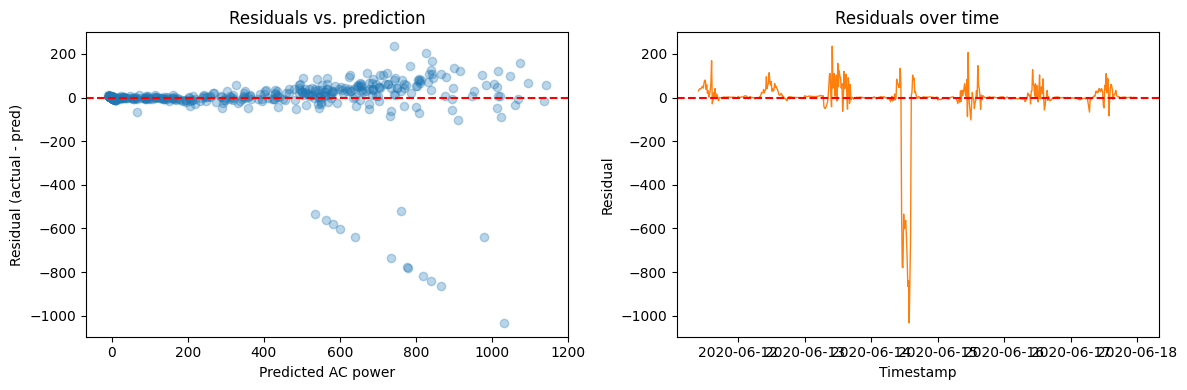

Poly(deg=2) residual mean = -5.8 kW (should stay near 0)
Poly(deg=2) residual std  = 112.8 kW


DATE_TIME
0      -1.305857
1      -0.325646
2      -0.463770
3      -0.919387
4      -0.109029
5       0.304742
6      -4.962765
7     -14.742566
8       4.254348
9      32.108080
10     55.231068
11    -58.184545
12    -49.106994
13   -105.571933
14    -15.971931
15     22.782613
16      7.329431
17     -2.830890
18      0.575232
19      1.821834
20      1.026555
21      0.479680
22     -0.312043
23     -0.695210
Name: Mean residual (kW), dtype: float64

In [ ]:
best_name = selection_df.iloc[0]["Model"]
best_model = candidates[best_name]
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_valid)
residuals = y_valid.values - y_pred
val_time = df_model["DATE_TIME"].iloc[split_idx:]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(y_pred, residuals, alpha=0.3, color="tab:blue")
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Predicted AC power")
axes[0].set_ylabel("Residual (actual - pred)")
axes[0].set_title("Residuals vs. prediction")
axes[1].plot(val_time, residuals, color="tab:orange", linewidth=1)
axes[1].axhline(0, color="red", linestyle="--")
axes[1].set_xlabel("Timestamp")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residuals over time")
plt.tight_layout()
plt.show()

print(f"{best_name} residual mean = {residuals.mean():.1f} kW (should stay near 0)")
print(f"{best_name} residual std  = {residuals.std():.1f} kW")

residual_series = pd.Series(residuals, index=val_time)
hourly_bias = residual_series.groupby(residual_series.index.hour).mean()

Residual-vs-prediction stays tight around zero
A few extreme points at both sides show the model misses some unusual conditions
Time plot is quite ok for most of the validation span, with a single day showing large negative residuals (model overestimation), likely tied to unmodeled cloudy conditions.
Hourly mean residuals hover near zero, so no systematic bias by time of day; focus next on adding features capturing those occasional abnormal days, that would mean capturing weather patterns beyond just irradiation and hour.

# 2.6 F. Dimensionality Reduction and Statistical Tests (40 points)

## **Part 1. Dimensionality Reduction (25 points)**

## PCA projection and interpretation (variance explained, what clusters or separations mean) (10 points)

Explained variance ratio: [0.76  0.194 0.035]
Cumulative variance: [0.76  0.954 0.989]


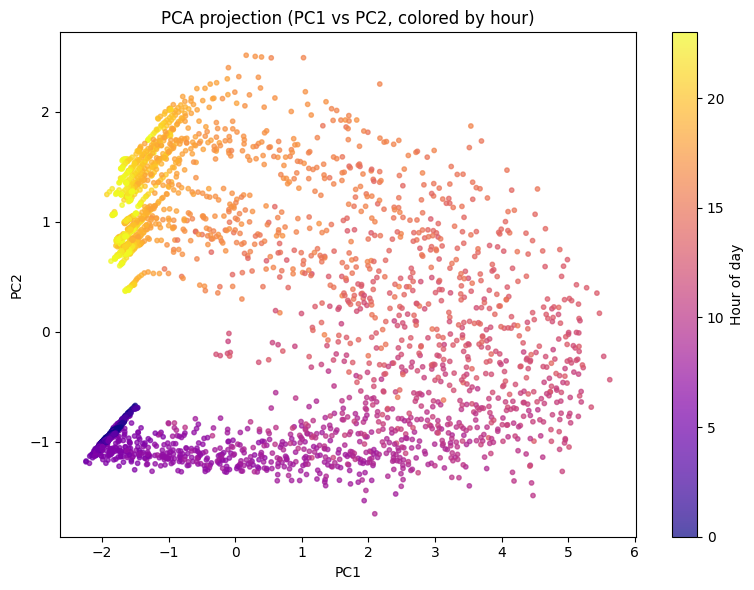

,PC1,PC2,PC3
MODULE_TEMPERATURE,0.462177,-0.010251,0.172908
AC_POWER,0.454829,-0.160952,-0.283198
DC_POWER,0.454804,-0.160949,-0.284269
IRRADIATION,0.454482,-0.157860,-0.186997
AMBIENT_TEMPERATURE,0.397742,0.361125,0.760621
DAILY_YIELD,0.089012,0.890367,-0.442245


In [141]:
pca_cols = ["AC_POWER", "DC_POWER", "IRRADIATION",
            "DAILY_YIELD", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]

pca_base = df_merged[["DATE_TIME"] + pca_cols].dropna().copy()
X_scaled = StandardScaler().fit_transform(pca_base[pca_cols])

pca = PCA(n_components=3, random_state=42)
components = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_

print("Explained variance ratio:", np.round(explained, 3))
print("Cumulative variance:", np.round(np.cumsum(explained), 3))

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(components[:, 0], components[:, 1],
                     c=pca_base["DATE_TIME"].dt.hour, cmap="plasma", s=10, alpha=0.7)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA projection (PC1 vs PC2, colored by hour)")
cbar = plt.colorbar(scatter, ax=ax, label="Hour of day")
plt.tight_layout()
plt.show()

loadings = pd.DataFrame(pca.components_.T, index=pca_cols,
                        columns=["PC1", "PC2", "PC3"])
display(loadings.sort_values("PC1", key=np.abs, ascending=False))

Variance:
The first two principal components capture over 95% of the data’s variation. This is expected because all six features are driven by the daily solar cycle, meaning just two dimensions can describe nearly the whole system.

Component meaning
PC1 represents solar intensity, combining power output, sunlight, and temperature. Night readings appear near zero, while midday values extend far along this axis.

PC2 separates daily energy yield (positive) from ambient temperature (negative), effectively distinguishing earlier hours from later ones based on accumulated energy production.

Clusters or separations
Plotting the two main components creates a smooth curve shaped by the sun's daily arc. The data doesn't form separate clusters. Instead, it flows continuously from night to noon and back to evening. Every point's position simply shows its time of day.

## t-SNE embedding with justified hyperparameters (perplexity or similar) and interpretation (7 points)

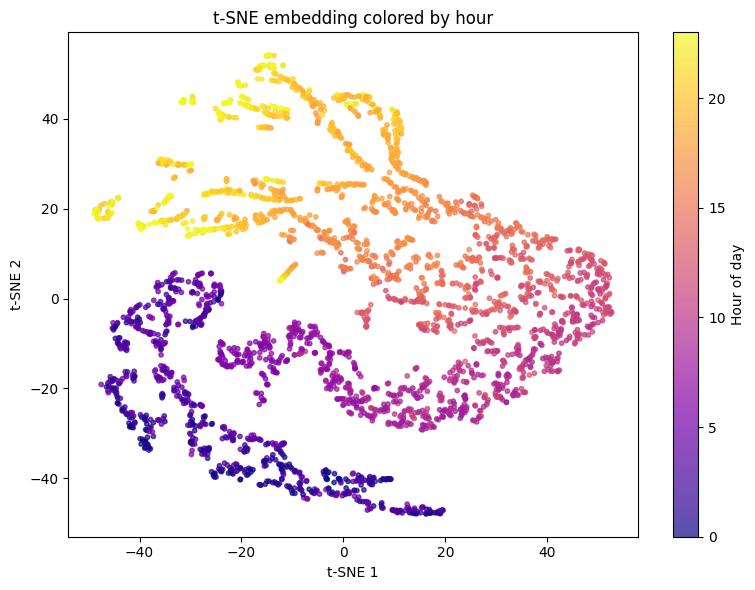

In [142]:
tsne = TSNE(
    n_components=2,
    perplexity=20,
    learning_rate="auto",
    max_iter=600,
    random_state=42,
    n_jobs=-1
)
tsne_coords = tsne.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(tsne_coords[:, 0], tsne_coords[:, 1],
                     c=pca_base["DATE_TIME"].dt.hour,
                     cmap="plasma", s=10, alpha=0.7)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE embedding colored by hour")
plt.colorbar(scatter, ax=ax, label="Hour of day")
plt.tight_layout()
plt.show()

t‑SNE now separates the sparse night readings from the daytime cloud: one compact lobe clusters the zero‑production points, while the second lobe covers the intervals with real output, leaving a thin gap where inputs were dropped.

## UMAP embedding with justified hyperparameters (neighbors, min dist or similar) and interpretation (8 points)

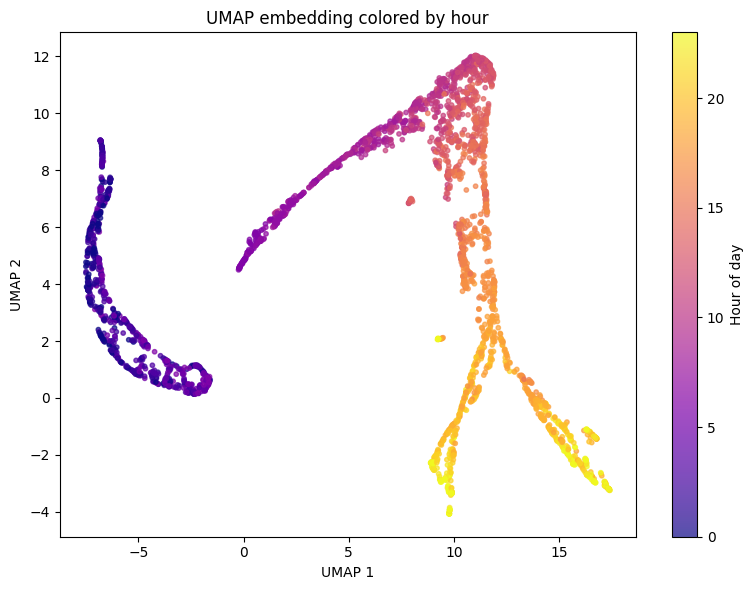

In [143]:
umap_model = UMAP(
    n_neighbors=40,
    min_dist=0.05,
    metric="euclidean",
    n_jobs=-1,
)
umap_coords = umap_model.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1],
                     c=pca_base["DATE_TIME"].dt.hour,
                     cmap="plasma", s=10, alpha=0.7)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title("UMAP embedding colored by hour")
plt.colorbar(scatter, ax=ax, label="Hour of day")
plt.tight_layout()
plt.show()

UMAP shows the same two regimes as t-sne but over a wider span. One quiet island for night/zero readings and another continuous arc for daytime generation—with the mid-gap marking missing samples.